# Projet 06 : Détecter des faux billets

---

## <font color=blue>Sommaire</font>

[1. Analyse des données sur les billets](#1_0)   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.1. Analyse univariée](#1_1)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.2. Analyse bivariée](#1_2)  
  
[2. Analyse en composantes principales (ACP)](#2_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1. Eboulis des valeurs propres](#2_1)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2. Cercles des corrélations](#2_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3. Projection des individus](#2_3)   
  
[3. Classification non supervisée](#3_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1. Choix du nombre de clusters](#3_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2. K-means avec 2 clusters](#3_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.3. K-means avec 4 clusters](#3_3)  
  
[4. Modélisation par une régression logistique](#4_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1. Régression logistique basée sur les données brutes de la base billets](#4_1)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1.1 Analyse et sélection du modèle sur les données d'entraînement](#4_1)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1.2 Validation croisée du modèle](#4_1_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1.3 Vérification sur les données de test](#4_1_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.2. Régression logistique basée sur les données de l'ACP](#4_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.2.1 Analyse et sélection du modèle sur les données d'entraînement](#4_2_1)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.2.2 Validation croisée du modèle](#4_2_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.2.3 Vérification sur les données de test](#4_2_3)  
  
[5. Prédictions](#5_0)  


---
**Importation des librairies**

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import joblib

import sf_stats_inferentielles as sfsi
import sf_classification_acp as sfca
import sf_graphiques as sfg
import sf_modeles_regression as sfmr
import sf_modeles_classif_supervisee as sfmcs

In [4]:
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.labelpad'] = 15
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['legend.framealpha'] = 1
plt.rcParams['legend.facecolor'] = (0.95,0.95,0.95)
plt.rcParams['legend.edgecolor'] = (0.95,0.95,0.95)
plt.rcParams['savefig.orientation'] = 'landscape'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

<a id="1_0"></a>

---
## <font color=blue>1. Analyse des données sur les billets</font>

**Importation des données**

In [5]:
billets = pd.read_csv("notes.csv")

In [6]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


In [7]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
is_genuine      170 non-null bool
diagonal        170 non-null float64
height_left     170 non-null float64
height_right    170 non-null float64
margin_low      170 non-null float64
margin_up       170 non-null float64
length          170 non-null float64
dtypes: bool(1), float64(6)
memory usage: 8.2 KB


Nous avons des données très propres : pas de données manquantes.
La table comporte 170 lignes et 7 colonnes. La première colonne de type booléen indique si le billet est vrai ou faux. Les 6 autres colonnes sont des nombres décimaux qui indiquent les dimensions des billets : diagonale, hauteur à gauche, hauteur à droite, marge du bas, marge du haut et longueur.

<a id="1_1"></a>

### <font color=blue>1.1. Analyse univariée</font>

Je regarde la **répartition entre les vrais et faux billets**.

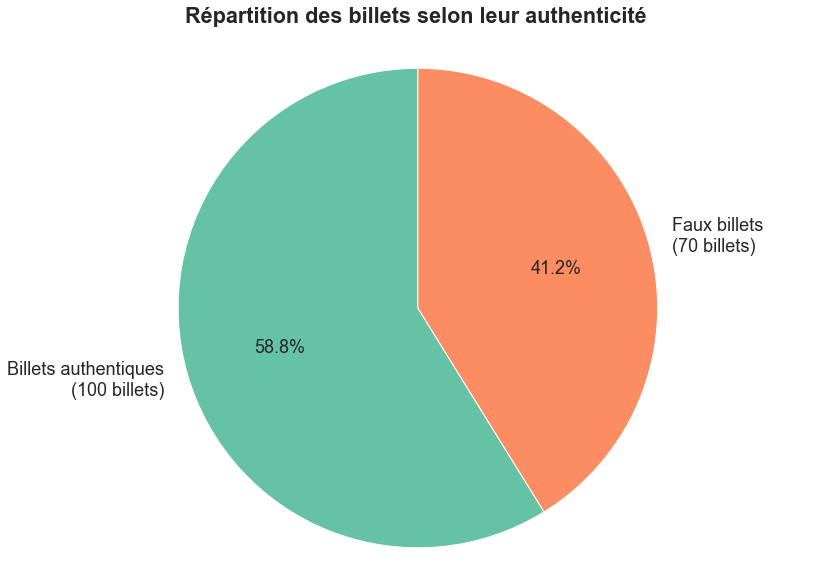

In [8]:
labels = ["Billets authentiques\n({} billets)".format(billets[billets.is_genuine==True].is_genuine.count()),\
          "Faux billets\n({} billets)".format(billets[billets.is_genuine==False].is_genuine.count())]
values = [billets[billets.is_genuine==True].is_genuine.count(),
         billets[billets.is_genuine==False].is_genuine.count()]

graph01 = sfg.MyGraph("Répartition des billets selon leur authenticité", is_mono=False)
graph01.add_pie(values, labels)
fig, ax = graph01.fig, graph01.ax
plt.savefig("p6_m0_g01_repart_billets.png")
plt.show()

Je calcule les **statistiques de valeur centrale et de dispersion des variables numériques**. Puis j'affiche les boxplots pour chacune de ces variables.

In [9]:
billets.describe(include='all')

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,170,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,100,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,NaN,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,NaN,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,NaN,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,NaN,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,NaN,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500


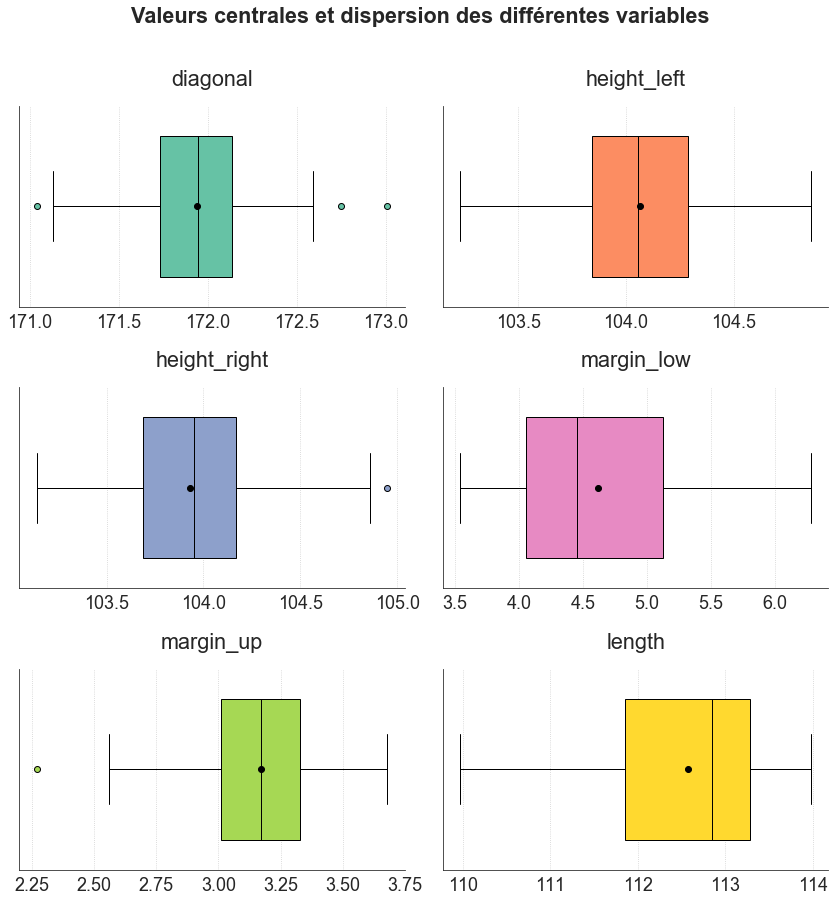

In [10]:
graph02 = sfg.MyGraph("Valeurs centrales et dispersion des différentes variables", nblin=3, nbcol=2, figsize=(12,12), is_mono=False)
for cpt in np.arange(len(billets.columns[1:])):
    valeurs = billets[billets.columns[cpt+1]].values
    cat_labels = [""]
    graph02.add_boxplot(valeurs, cat_labels, means=True, vertical=False, subtitle=billets.columns[cpt+1], multi_index=cpt+1)
fig, ax = graph02.fig, graph02.ax
plt.savefig("p6_m0_g02_distrib_billets.png")
plt.show()

In [11]:
graph02b = sfg.MyGraph("Valeurs centrales et dispersion des différentes variables", nblin=2, nbcol=3, figsize=(12,8), is_mono=False)
for cpt in np.arange(len(billets.columns[1:])):
    valeurs = billets[billets.columns[cpt+1]].values
    cat_labels = [""]
    graph02b.add_boxplot(valeurs, cat_labels, means=True, vertical=True, subtitle=billets.columns[cpt+1], multi_index=cpt+1)
fig, ax = graph02b.fig, graph02b.ax
plt.savefig("p6_m0_g02b_distrib_billets.png")
plt.close(fig)

Les boxplot confirment que les données sont très propres. Il n'y a que 3 outliers pour la diagonale, 1 pour la hauteur à droite et 1 pour la marge du haut.  
Je constate que l'écart interquantile est plus large pour deux variables : la longueur et la marge inférieure.

Je compare maintenant les valeurs centrales et de dispersion pour ces mêmes variables, pour les billets authentiques et les faux billets.

In [12]:
billets[billets.is_genuine==True].describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,171.976100,103.951500,103.775900,4.143500,3.055500,113.207200
std,0.307981,0.296251,0.292406,0.314509,0.197726,0.380476
min,171.040000,103.230000,103.140000,3.540000,2.270000,111.760000
25%,171.790000,103.740000,103.557500,3.900000,2.937500,112.995000
50%,172.005000,103.915000,103.760000,4.080000,3.070000,113.210000
75%,172.162500,104.145000,103.972500,4.382500,3.192500,113.505000
max,172.750000,104.860000,104.950000,5.040000,3.530000,113.980000


In [13]:
billets[billets.is_genuine==False].describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,171.889857,104.230429,104.145571,5.281571,3.334571,111.660714
std,0.297426,0.213130,0.253152,0.540846,0.185102,0.676931
min,171.380000,103.780000,103.440000,3.820000,2.980000,109.970000
25%,171.682500,104.082500,103.982500,4.952500,3.185000,111.270000
50%,171.875000,104.215000,104.170000,5.265000,3.335000,111.765000
75%,172.047500,104.377500,104.280000,5.702500,3.450000,111.985000
max,173.010000,104.720000,104.860000,6.280000,3.680000,113.640000


Analysons avec des **tests statistiques les différences de variance et de moyenne entre les vrais et les faux billets pour les différentes variables**. Vérifions d'abord que les variables sont gaussiennes.

In [14]:
for col in billets.columns[1:]:
    temp = sfsi.OneSample(billets[col].values)
    print("variable {} : {}".format(col, temp.comment_test_normalite(short_comment=True)))

variable diagonal : Le test conclut que la distribution de l'échantillon suit une loi normale.
variable height_left : Le test conclut que la distribution de l'échantillon suit une loi normale.
variable height_right : Le test conclut que la distribution de l'échantillon suit une loi normale.
variable margin_low : Le test conclut que la distribution de l'échantillon ne suit pas une loi normale.
variable margin_up : Le test conclut que la distribution de l'échantillon suit une loi normale.
variable length : Le test conclut que la distribution de l'échantillon ne suit pas une loi normale.


Le test conclut que 4 variables suivent une loi normale au niveau de test 5% : diagonal, height_left, height_right et margin_up.  
Les deux variables margin_low et length se distinguent car le test rejette l'hypothèse de normalité au niveau de test 5%. Je regarde en détail les conclusions pour ces 2 variables.

In [15]:
temp = sfsi.OneSample(billets.margin_low)
print(temp.comment_test_normalite())

Test de normalité de Shapiro-Wilk pour l'échantillon de taille 170.
La statistique testée est W = 0.935
La p_value 0.000 est inférieure à alpha 0.050. L'hypothèse que la distribution de l'échantillon suit une loi normale est rejetée avec un niveau de risque de 5.00%. Le test conclut que la distribution de l'échantillon ne suit pas une loi normale.


In [16]:
temp = sfsi.OneSample(billets.length)
print(temp.comment_test_normalite())

Test de normalité de Shapiro-Wilk pour l'échantillon de taille 170.
La statistique testée est W = 0.932
La p_value 0.000 est inférieure à alpha 0.050. L'hypothèse que la distribution de l'échantillon suit une loi normale est rejetée avec un niveau de risque de 5.00%. Le test conclut que la distribution de l'échantillon ne suit pas une loi normale.


La p-value est inférieure à 0.001 pour les deux variables. Donc l'hypothèse de normalité est rejetée pour les deux variables quelque soit le niveau de test.

Je réalise des tests statistiques sur les 4 variables gaussiennes, afin d'évaluer si les 2 échantillons de billets (authentiques et faux) présentent des caractéristiques similaires sur ces 4 variables.  
Je commence par tester l'égalité des variances, puis je teste l'égalité des moyennes (en spécifiant si les variances sont égales ou non). Au niveau de test 5% dans tous les cas.

In [17]:
truenotes = billets[billets.is_genuine==True][["diagonal","height_left","height_right","margin_up"]]
falsenotes = billets[billets.is_genuine==False][["diagonal","height_left","height_right","margin_up"]]

In [18]:
for cpt in np.arange(4):
    temp = sfsi.TwoSamples(truenotes[truenotes.columns[cpt]], falsenotes[falsenotes.columns[cpt]])
    print("Egalité des variances pour la variable {} : {}".format(truenotes.columns[cpt], temp.comment_variance_ratio_fishertest(short_comment=True)))

Egalité des variances pour la variable diagonal : Le test conclut que la variance de x est égale à la variance de y.
Egalité des variances pour la variable height_left : Le test conclut que la variance de x est différente de la variance de y.
Egalité des variances pour la variable height_right : Le test conclut que la variance de x est égale à la variance de y.
Egalité des variances pour la variable margin_up : Le test conclut que la variance de x est égale à la variance de y.


In [19]:
# je regarde le résultat détaillé pour height_left
cpt = 1
temp = sfsi.TwoSamples(truenotes[truenotes.columns[cpt]], falsenotes[falsenotes.columns[cpt]])
print(temp.comment_variance_ratio_fishertest())

Test F de Fisher pour comparer les variances de deux échantillons de taille 100 et 70.
On teste la statistique F = 1.9320958501262129 avec la loi de Fisher à 99 et 69 degrés de liberté.
Le ratio des deux variances est estimé à 1.9320958501262129 et est compris dans l'intervalle (1.236310447328993, 2.9676486316068678) avec un niveau de confiance de 95.00%.
La p_value 0.004 est inférieure à alpha 0.050. L'hypothèse H0 que la variance de x est égale à la variance de y est rejetée avec un niveau de risque de 5.00%. Le test conclut que la variance de x est différente de la variance de y.


In [20]:
for cpt in np.arange(4):
    if cpt != 1:
        temp = sfsi.TwoSamples(truenotes[truenotes.columns[cpt]], falsenotes[falsenotes.columns[cpt]], var_equal=True)
    else:
        temp = sfsi.TwoSamples(truenotes[truenotes.columns[cpt]], falsenotes[falsenotes.columns[cpt]], var_equal=False)
    print("Egalité des moyennes pour la variable {} : {}".format(truenotes.columns[cpt], temp.comment_mean_difference_ttest(short_comment=True)))

Egalité des moyennes pour la variable diagonal : Le test conclut que la moyenne de x est égale à la moyenne de y.
Egalité des moyennes pour la variable height_left : Le test conclut que la moyenne de x est différente de la moyenne de y.
Egalité des moyennes pour la variable height_right : Le test conclut que la moyenne de x est différente de la moyenne de y.
Egalité des moyennes pour la variable margin_up : Le test conclut que la moyenne de x est différente de la moyenne de y.


Plus en détail lorsque l'hypothèse d'égalité est rejetée :

In [21]:
for cpt in np.arange(1, 4):
    if cpt != 1:
        temp = sfsi.TwoSamples(truenotes[truenotes.columns[cpt]], falsenotes[falsenotes.columns[cpt]], var_equal=True)
    else:
        temp = sfsi.TwoSamples(truenotes[truenotes.columns[cpt]], falsenotes[falsenotes.columns[cpt]], var_equal=False)
    print("Variable {}\n{}\n".format(truenotes.columns[cpt], temp.comment_mean_difference_ttest()))

Variable height_left
Méthode = test t de Welch pour comparer les moyennes de deux échantillons avec des variances différentes.
On teste la statistique T = -7.138967397007879 avec la loi de Student à 167.86 degrés de liberté.
La différence entre les moyennes de x et de y est estimée à -0.27892857142857963 et est comprise dans l'intervalle (-0.35606298507216827, -0.20179415778499096) avec un niveau de confiance de 95.00%.
La p_value 0.000 est inférieure à alpha 0.050. L'hypothèse H0 que la moyenne de x est égale à la moyenne de y est rejetée avec un niveau de risque de 5.00%. Le test conclut que la moyenne de x est différente de la moyenne de y.

Variable height_right
Méthode = test t de student pour comparer les moyennes de deux échantillons avec la même variance.
On teste la statistique T = -8.564989194564754 avec la loi de Student à 168.00 degrés de liberté.
La différence entre les moyennes de x et de y est estimée à -0.3696714285714222 et est comprise dans l'intervalle (-0.4548787584

Les différences de moyenne sont très nettes (p-value < 0.001).

**En résumé, les tests nous indiquent pour les 4 variables gaussiennes que** :
- variable diagonal : la variance et la moyenne sont les mêmes pour les vrais et les faux billets ;
- variable height_left : la variance et la moyenne sont différentes pour les vrais et les faux billets ;
- variables height_right et margin-up : la variance est similaire mais la moyenne est différente pour les vrais et les faux billets.

Je réalise le test non-paramétrique de Mann et Whitney sur les 2 variables non gaussiennes, pour étudier si leur distribution peut être considérée comme similaire pour les vrais et les faux billets. Si l'hyptohèse de distribution similaire est acceptée, on pourra considérer que leur médiane est égale pour les échantillons des vrais billets et des faux billets (médiane plutôt que moyenne car les données sont ordonnées pour ce test).

In [22]:
truenotes = billets[billets.is_genuine==True][["margin_low","length"]]
falsenotes = billets[billets.is_genuine==False][["margin_low","length"]]
for col in truenotes.columns:
    temp = sfsi.TwoSamples(truenotes[col].values, falsenotes[col].values)
    print("Variable {}\n{}\n".format(col, temp.comment_non_parametric_test()))

Variable margin_low
Test non paramétrique de Mann-Whitney pour les échantillons de taille 100 et 70.
La statistique testée est U = 306.000
La p_value 0.000 est inférieure à alpha 0.050. L'hypothèse que les deux échantillons ont une distribution similaire est rejetée avec un niveau de risque de 5.00%. Nous pouvons considérer que leurs médianes sont différentes.

Variable length
Test non paramétrique de Mann-Whitney pour les échantillons de taille 100 et 70.
La statistique testée est U = 226.000
La p_value 0.000 est inférieure à alpha 0.050. L'hypothèse que les deux échantillons ont une distribution similaire est rejetée avec un niveau de risque de 5.00%. Nous pouvons considérer que leurs médianes sont différentes.



Les échantillons de vrais billets et de faux billets semblent bien distincts du point de vue des variables margin_low et length.  
Le t-test d'égalite des moyennes, en forçant l'inégalité des variances, est plus précis que le test de Mann-Whitney, dans certains cas.  J'effectue ce t-test pour voir s'il confirme mes premières conclusions.

In [23]:
for col in truenotes.columns:
    temp = sfsi.TwoSamples(truenotes[col].values, falsenotes[col].values, var_equal=False)
    print("Variable {}\n{}\n".format(col, temp.comment_mean_difference_ttest()))

Variable margin_low
Méthode = test t de Welch pour comparer les moyennes de deux échantillons avec des variances différentes.
On teste la statistique T = -15.83108408060998 avec la loi de Student à 101.57 degrés de liberté.
La différence entre les moyennes de x et de y est estimée à -1.138071428571429 et est comprise dans l'intervalle (-1.2806690624656503, -0.9954737946772078) avec un niveau de confiance de 95.00%.
La p_value 0.000 est inférieure à alpha 0.050. L'hypothèse H0 que la moyenne de x est égale à la moyenne de y est rejetée avec un niveau de risque de 5.00%. Le test conclut que la moyenne de x est différente de la moyenne de y.

Variable length
Méthode = test t de Welch pour comparer les moyennes de deux échantillons avec des variances différentes.
On teste la statistique T = 17.296894051177798 avec la loi de Student à 99.50 degrés de liberté.
La différence entre les moyennes de x et de y est estimée à 1.546485714285751 et est comprise dans l'intervalle (1.3690912974321492, 

Cela confirme mon premier test.

**Pour résumer les tests statistiques :**  
Les échantillons de vrais et faux billets sont identiques du point de vue de la variable diagonal.  
Ils diffèrent du point de vue des 5 autres variables.

**Boxplots de résumé de chaque variable en distinguant les vrais et faux billets**

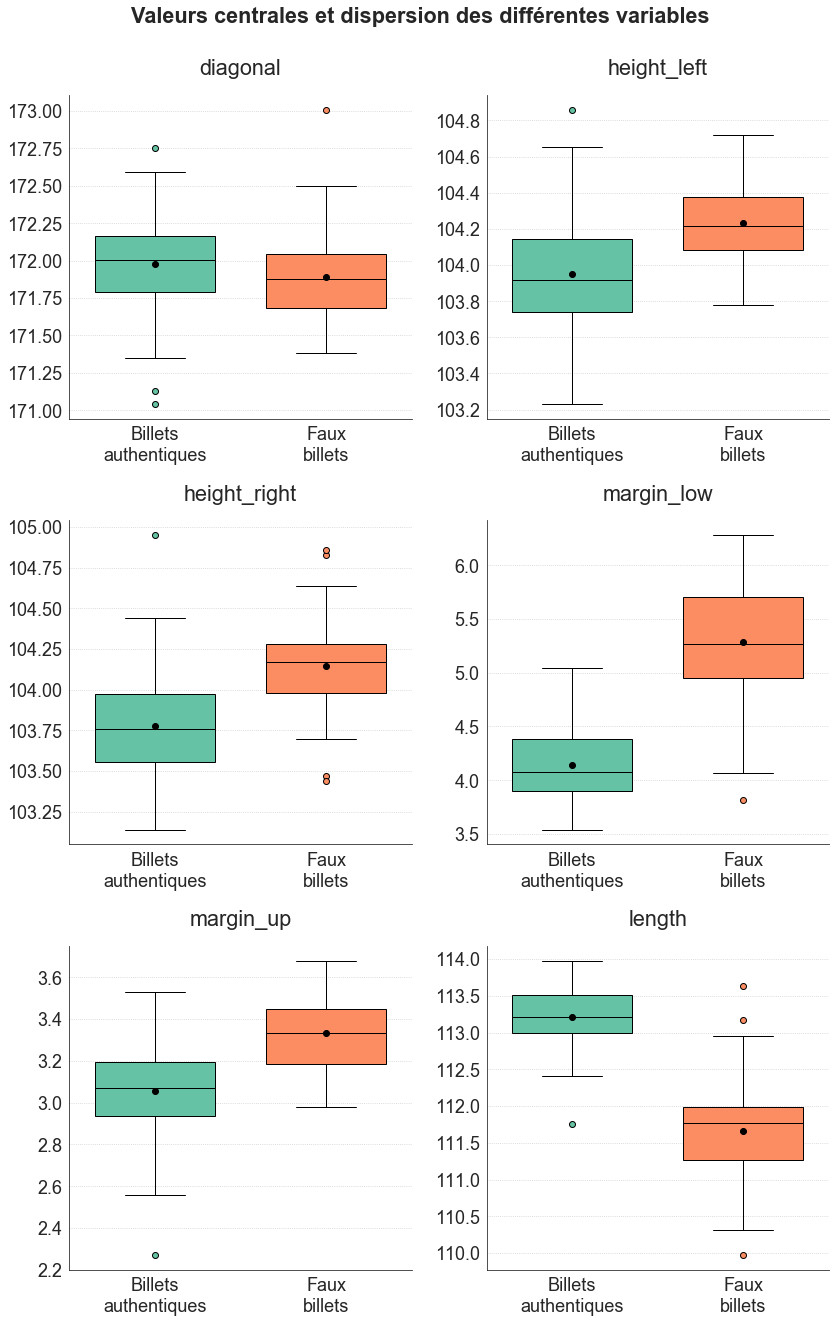

In [24]:
graph03 = sfg.MyGraph("Valeurs centrales et dispersion des différentes variables", nblin=3, nbcol=2, figsize=(12,18), is_mono=False)
for cpt in np.arange(len(billets.columns[1:])):
    valeurs = [billets[billets.is_genuine==True][col].values, \
           billets[billets.is_genuine==False][col].values]
    valeurs = [billets[billets.is_genuine==True][billets.columns[cpt+1]].values,
               billets[billets.is_genuine==False][billets.columns[cpt+1]].values]
    cat_labels = ["Billets\nauthentiques","Faux\nbillets"]
    graph03.add_boxplot(valeurs, cat_labels, color_base_index=0, means=True, vertical=True, subtitle=billets.columns[cpt+1], multi_index=cpt+1)
fig, ax = graph03.fig, graph03.ax
fig.suptitle(fig._suptitle.get_text(), y=1.025)
plt.savefig("p6_m0_g03_distrib_billets_separes.png")
plt.show()

In [25]:
graph03b = sfg.MyGraph("Valeurs centrales et dispersion des différentes variables", nblin=2, nbcol=3, figsize=(16,12), is_mono=False)
for cpt in np.arange(len(billets.columns[1:])):
    valeurs = [billets[billets.is_genuine==True][col].values, \
           billets[billets.is_genuine==False][col].values]
    valeurs = [billets[billets.is_genuine==True][billets.columns[cpt+1]].values,
               billets[billets.is_genuine==False][billets.columns[cpt+1]].values]
    cat_labels = ["Billets\nauthentiques","Faux\nbillets"]
    graph03b.add_boxplot(valeurs, cat_labels, color_base_index=0, means=True, vertical=True, subtitle=billets.columns[cpt+1], multi_index=cpt+1)
fig, ax = graph03b.fig, graph03b.ax
plt.savefig("p6_m0_g03b_distrib_billets_separes.png")
plt.close(fig)

**Les boxplot montrent que les faux billets se distinguent le mieux des vrais billets par les variables margin_low et length.**  
Les variables height_right (voire height_left) et margin_up peuvent aider à compléter l'analyse. La variable diagonal ne semble pas discriminante.

<a id="1_2"></a>

### <font color=blue>1.1. Analyse bivariée</font>

Je commence par afficher le **pairplot** des données pour repérer les analyses bi-variées intéressantes à mener.
Je dois transformer la colonne is_genuine en string pour pouvoir afficher les points selon que les billets sont vrais ou faux.

In [26]:
str_genuine = billets.is_genuine.astype('str')
data = billets.iloc[:,1:]
data["is_genuine"] = str_genuine

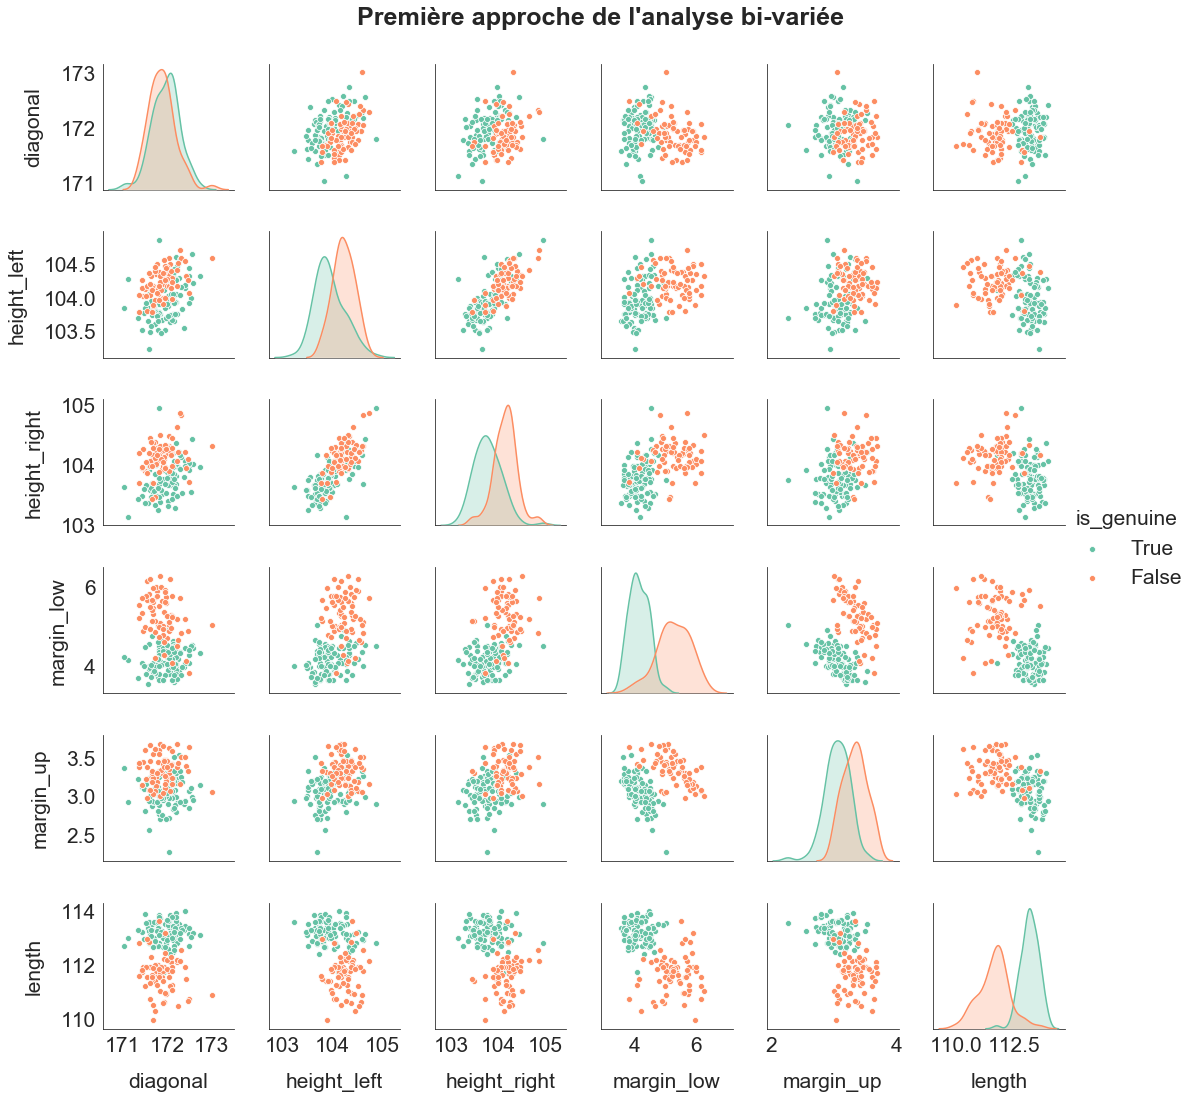

In [27]:
sns.pairplot(data, hue='is_genuine')
plt.suptitle("Première approche de l'analyse bi-variée", y=1.025)
plt.savefig("p6_m0_g04_pairplot.png")
plt.show()

Ces graphiques vont dans le sens de mes premières constatations. Les deux variables clés pour discrimer les vrais billets des faux billets semblent être les variables length et margin_low. En effet, les vrais et faux billets sont bien séparés par les analyses bi-variées qui impliquent ces deux mesures et une autre mesure. La variable margin_up permet également une discrimination, mais elle est moins nette.

Toutes mes variables sont quantitatives. Je calcule la **matrice de corrélation entre les 6 variables**, afin d'avoir une vue synthétique de leurs interractions.

C:\Anaconda3\envs\Jupyter\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


L'analyse a été calculée


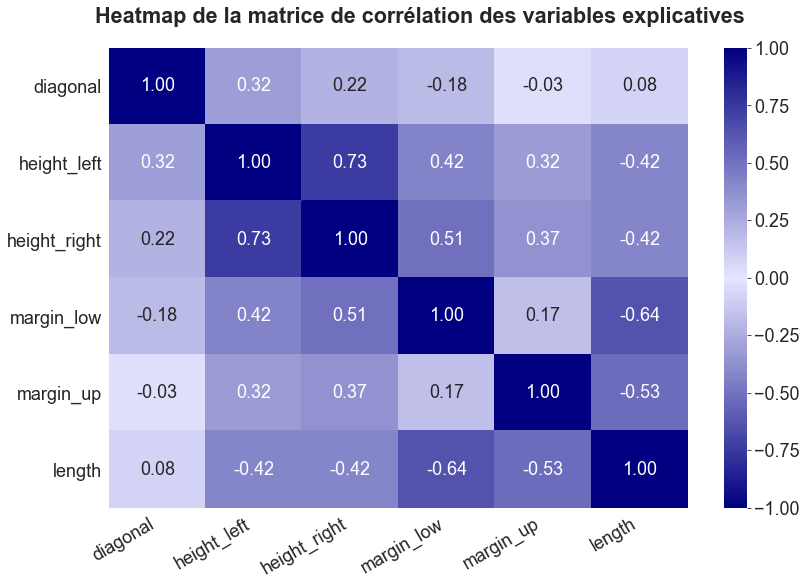

In [28]:
correl_all = sfmcs.LogisticRegressionAnalysis(data=billets, y_name="is_genuine", array_X_names=billets.columns[1:], with_standardization=False)
fig, ax = correl_all.graph_heatmap_correlationmatrix()
plt.savefig("p6_m0_g10_correlations.png")
plt.show()

La matrice de corrélation montre que les deux variables les plus corrélées sont height_left et height_right. Il semble logique que les 2 hauteurs soient fortement liées étant donné que le billet est théoriquement un rectangle.  
  
La longueur et la marge inférieure sont très anti-corrélées (coefficient de Pearson = -0.64). Cet aspect est à investiguer car ce sont les 2 variables qui séparent le mieux les vrais billets des faux billets.  
  
Enfin, les marges inférieures et les marges supérieures semblent peu corrélées. Cette constatation mérite également une étude plus approfondie car je m'attendais a priori à ce que ces 2 variables soient plus étroitement liées.

Je calcule le **coefficient de corrélation et j'estime la droite de régression linéaire pour les paires de variables que je souhaite analyser plus précisément**.  
  
En terme de corrélation, les variables height_right et height_left semblent avoir une relation linéaire forte. A l'inverse, la paire length / diagonal ne semble pas du tout corrélée. Je commence par étudier ces deux paires de variables.  

Puis j'étudierai les paires de variables discriminantes, en me concentrant sur l'interaction entre les 3 variables les plus discriminantes : length, magin_up et margin_low.

**Paire height_right - height_left**

In [29]:
correl01 = sfmr.LinearRegressionAnalysis(data=billets, y_name="height_left", array_X_names=["height_right"], with_standardization=False)

L'analyse a été calculée


In [30]:
correl01.df_linear_correl

,height_right
height_left,
Personn Correlation,0.73439
p-value - H0:r=0,4.41962e-30
Test result (alpha = 5%),Corrélation significative


In [31]:
print("La relation est estimée par l'équation : {}".format(correl01.equation))

La relation est estimée par l'équation : height_left = 0.662 * height_right + 35.305


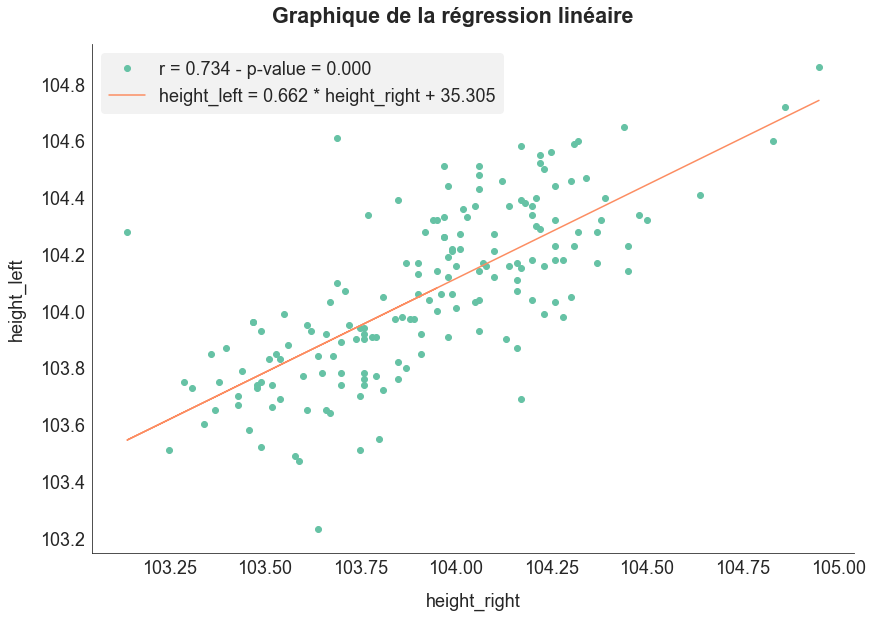

In [32]:
fig, ax = correl01.graph_linear_regression()
plt.show()

La liaison linéaire entre les deux hauteurs est forte, avec une corrélation de Pearson de 0.734.

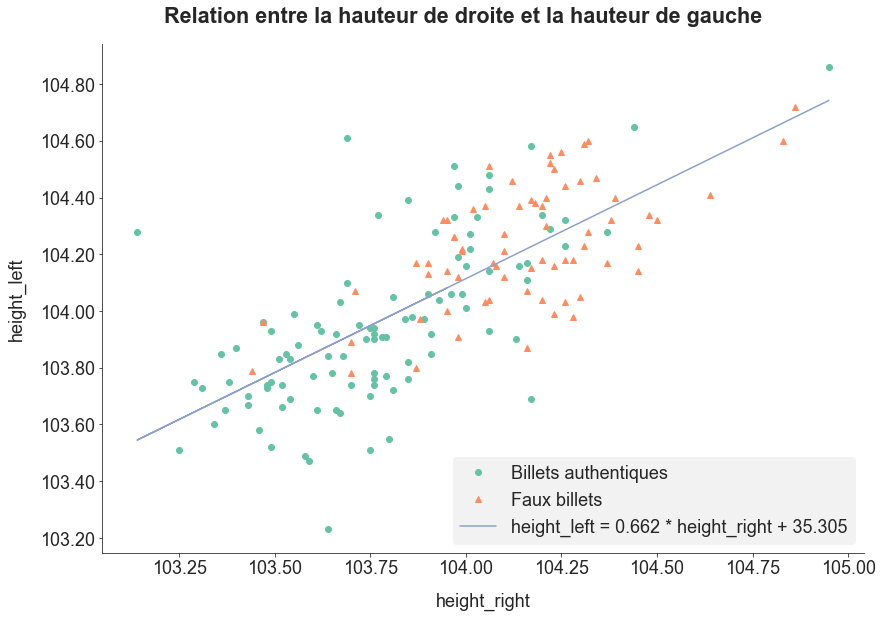

In [33]:
graph04 = sfg.MyGraph(title="Relation entre la hauteur de droite et la hauteur de gauche", is_mono=False)
graph04.add_plot(billets[billets.is_genuine==True][correl01.variables_retenues], billets[billets.is_genuine==True][correl01.variable_estimee], \
               label="Billets authentiques", marker='o', linestyle="")
graph04.add_plot(billets[billets.is_genuine==False][correl01.variables_retenues], billets[billets.is_genuine==False][correl01.variable_estimee], \
               label="Faux billets", marker='^', linestyle="")
graph04.add_plot(correl01.rawdata[correl01.variables_retenues], correl01.y_estimates, label=correl01.equation, legend=True)
graph04.set_axe('x', label=correl01.variables_retenues[0], tick_dash=True, tick_labels_format=':.2f')
graph04.set_axe('y', label=correl01.variable_estimee, tick_dash=True, tick_labels_format=':.2f')
fig, ax = graph04.fig, graph04.ax
plt.savefig("p6_m0_g12_heights.png")
plt.show()

On remarque que les faux billets tendent à avoir des hauteurs moyennes supérieures aux vrais billets. Cependant, beaucoup de mesures s'entremêlent.

**Paire length - diagonal**

In [34]:
correl03 = sfmr.LinearRegressionAnalysis(data=billets, y_name="length", array_X_names=["diagonal"], with_standardization=False)
correl03.df_linear_correl

L'analyse a été calculée


,diagonal
length,
Personn Correlation,0.0802952
p-value - H0:r=0,0.297932
Test result (alpha = 5%),Absence de corrélation


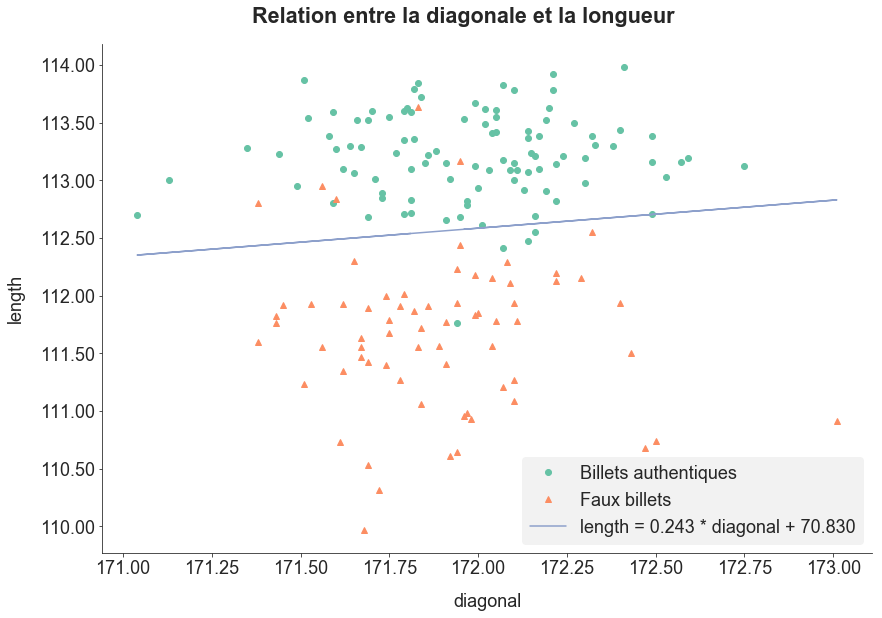

In [35]:
graph06 = sfg.MyGraph(title="Relation entre la diagonale et la longueur", is_mono=False)
graph06.add_plot(billets[billets.is_genuine==True][correl03.variables_retenues], billets[billets.is_genuine==True][correl03.variable_estimee], \
               label="Billets authentiques", marker='o', linestyle="")
graph06.add_plot(billets[billets.is_genuine==False][correl03.variables_retenues], billets[billets.is_genuine==False][correl03.variable_estimee], \
               label="Faux billets", marker='^', linestyle="")
graph06.add_plot(correl03.rawdata[correl03.variables_retenues], correl03.y_estimates, label=correl03.equation, legend=True)
graph06.set_axe('x', label=correl03.variables_retenues[0], tick_dash=True, tick_labels_format=':.2f')
graph06.set_axe('y', label=correl03.variable_estimee, tick_dash=True, tick_labels_format=':.2f')
fig, ax = graph06.fig, graph06.ax
plt.savefig("p6_m0_g05_diagonal_length.png")
plt.show()

Comme je m'y attendais, la corrélation linéaire entre la longueur et la diagonale n'est pas significative. Je note que la droite de la régression sépare assez bien les vrais billets des faux billets.

**Paire length - margin_low**

In [36]:
correl07 = sfmr.LinearRegressionAnalysis(data=billets, y_name="length", array_X_names=["margin_low"], with_standardization=False)
correl07.df_linear_correl

L'analyse a été calculée


,margin_low
length,
Personn Correlation,-0.637352
p-value - H0:r=0,9.23258e-21
Test result (alpha = 5%),Corrélation significative


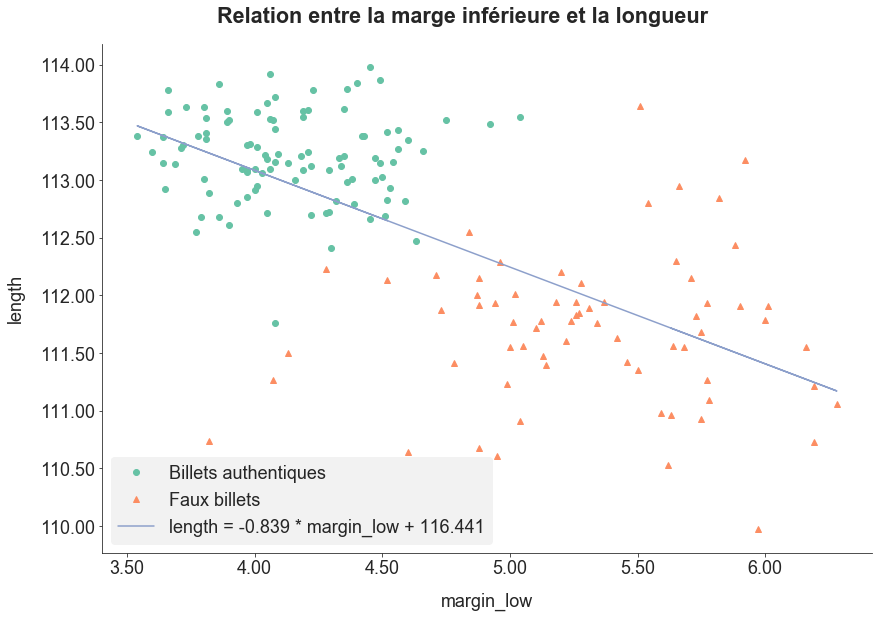

In [37]:
graph09 = sfg.MyGraph(title="Relation entre la marge inférieure et la longueur", is_mono=False)
graph09.add_plot(billets[billets.is_genuine==True][correl07.variables_retenues], billets[billets.is_genuine==True][correl07.variable_estimee], \
               label="Billets authentiques", marker='o', linestyle="")
graph09.add_plot(billets[billets.is_genuine==False][correl07.variables_retenues], billets[billets.is_genuine==False][correl07.variable_estimee], \
               label="Faux billets", marker='^', linestyle="")
graph09.add_plot(correl07.rawdata[correl07.variables_retenues], correl07.y_estimates, label=correl07.equation, legend=True)
graph09.set_axe('x', label=correl07.variables_retenues[0], tick_dash=True, tick_labels_format=':.2f')
graph09.set_axe('y', label=correl07.variable_estimee, tick_dash=True, tick_labels_format=':.2f')
fig, ax = graph09.fig, graph09.ax
plt.show()

Même chose en séparant billets authentiques et faux billets

In [38]:
correl08 = sfmr.LinearRegressionAnalysis(data=billets[billets.is_genuine==True], y_name="length", array_X_names=["margin_low"], with_standardization=False)
correl08.df_linear_correl

L'analyse a été calculée


,margin_low
length,
Personn Correlation,-0.0321543
p-value - H0:r=0,0.750802
Test result (alpha = 5%),Absence de corrélation


In [39]:
correl09 = sfmr.LinearRegressionAnalysis(data=billets[billets.is_genuine==False], y_name="length", array_X_names=["margin_low"], with_standardization=False)
correl09.df_linear_correl

L'analyse a été calculée


,margin_low
length,
Personn Correlation,0.116397
p-value - H0:r=0,0.337267
Test result (alpha = 5%),Absence de corrélation


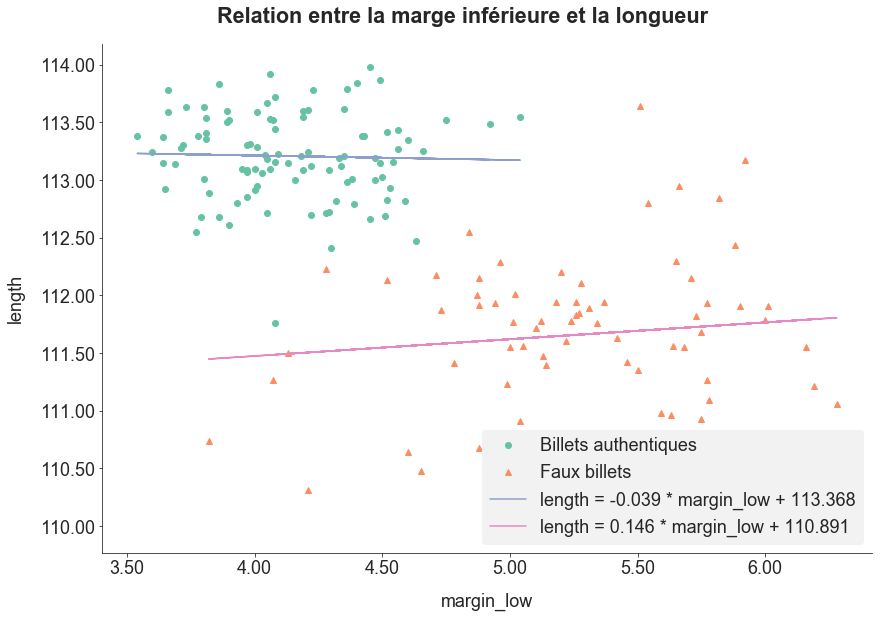

In [40]:
graph10 = sfg.MyGraph(title="Relation entre la marge inférieure et la longueur", is_mono=False)
graph10.add_plot(correl08.rawdata[correl08.variables_retenues], correl08.rawdata[correl08.variable_estimee], \
               label="Billets authentiques", marker='o', linestyle="")
graph10.add_plot(correl09.rawdata[correl09.variables_retenues], correl09.rawdata[correl09.variable_estimee], \
               label="Faux billets", marker='^', linestyle="")
graph10.add_plot(correl08.rawdata[correl08.variables_retenues], correl08.y_estimates, label=correl08.equation)
graph10.add_plot(correl09.rawdata[correl09.variables_retenues], correl09.y_estimates, label=correl09.equation, legend=True)
graph10.set_axe('x', label=correl08.variables_retenues[0], tick_dash=True, tick_labels_format=':.2f')
graph10.set_axe('y', label=correl08.variable_estimee, tick_dash=True, tick_labels_format=':.2f')
fig, ax = graph10.fig, graph10.ax
plt.show()

La corrélation entre la longueur et la marge inférieure (-0.637) est significative lorsque l'on considère la population totale des billets.  
Les régressions sur les billets authentiques d'une part et sur les faux billets d'autre part donnent deux droites très distinctes entre elles et avec la régression sur la totalité des billets. La corrélation entre la longueur et la marge inférieure n'est plus significative lorsque l'on analyse d'un côté les vrais billets et de l'autre les faux billets.  
Ces deux mesures semblent donc complémentaires pour séparer les vrais billets et les faux billets.

**Paire margin_low - margin_up**

In [41]:
correl10 = sfmr.LinearRegressionAnalysis(data=billets, y_name="margin_low", array_X_names=["margin_up"], with_standardization=False)
correl10.df_linear_correl

L'analyse a été calculée


,margin_up
margin_low,
Personn Correlation,0.171113
p-value - H0:r=0,0.0256772
Test result (alpha = 5%),Corrélation significative


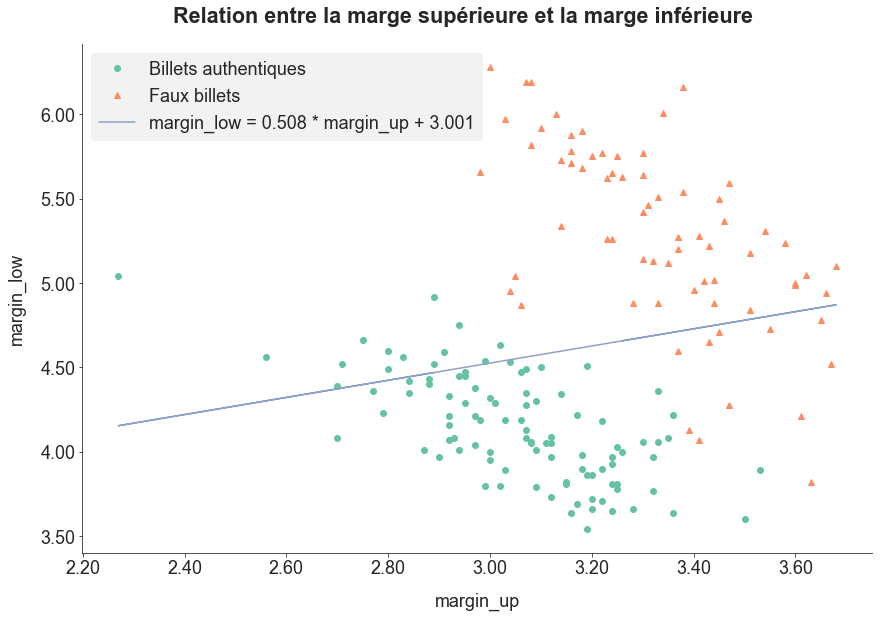

In [42]:
graph11 = sfg.MyGraph(title="Relation entre la marge supérieure et la marge inférieure", is_mono=False)
graph11.add_plot(billets[billets.is_genuine==True][correl10.variables_retenues], billets[billets.is_genuine==True][correl10.variable_estimee], \
               label="Billets authentiques", marker='o', linestyle="")
graph11.add_plot(billets[billets.is_genuine==False][correl10.variables_retenues], billets[billets.is_genuine==False][correl10.variable_estimee], \
               label="Faux billets", marker='^', linestyle="")
graph11.add_plot(correl10.rawdata[correl10.variables_retenues], correl10.y_estimates, label=correl10.equation, legend=True)
graph11.set_axe('x', label=correl10.variables_retenues[0], tick_dash=True, tick_labels_format=':.2f')
graph11.set_axe('y', label=correl10.variable_estimee, tick_dash=True, tick_labels_format=':.2f')
fig, ax = graph11.fig, graph11.ax
plt.show()

Même chose en séparant billets authentiques et faux billets

In [43]:
correl11 = sfmr.LinearRegressionAnalysis(data=billets[billets.is_genuine==True], y_name="margin_low", array_X_names=["margin_up"], with_standardization=False)
correl11.df_linear_correl

L'analyse a été calculée


,margin_up
margin_low,
Personn Correlation,-0.651187
p-value - H0:r=0,2.21227e-13
Test result (alpha = 5%),Corrélation significative


In [44]:
correl12 = sfmr.LinearRegressionAnalysis(data=billets[billets.is_genuine==False], y_name="margin_low", array_X_names=["margin_up"], with_standardization=False)
correl12.df_linear_correl

L'analyse a été calculée


,margin_up
margin_low,
Personn Correlation,-0.61812
p-value - H0:r=0,1.1895e-08
Test result (alpha = 5%),Corrélation significative


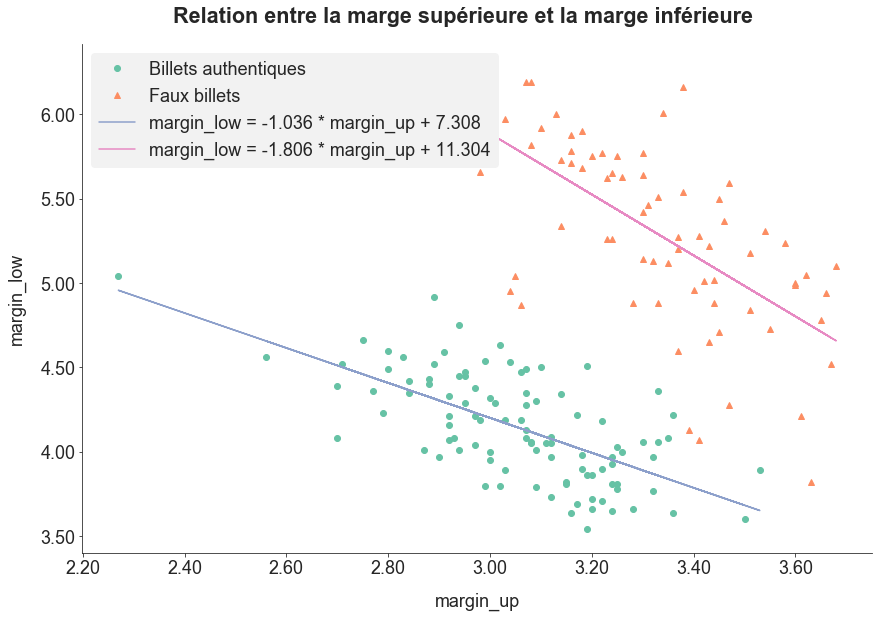

In [45]:
graph12 = sfg.MyGraph(title="Relation entre la marge supérieure et la marge inférieure", is_mono=False)
graph12.add_plot(correl11.rawdata[correl11.variables_retenues], correl11.rawdata[correl11.variable_estimee], \
               label="Billets authentiques", marker='o', linestyle="")
graph12.add_plot(correl12.rawdata[correl12.variables_retenues], correl12.rawdata[correl12.variable_estimee], \
               label="Faux billets", marker='^', linestyle="")
graph12.add_plot(correl11.rawdata[correl11.variables_retenues], correl11.y_estimates, label=correl11.equation)
graph12.add_plot(correl12.rawdata[correl12.variables_retenues], correl12.y_estimates, label=correl12.equation, legend=True)
graph12.set_axe('x', label=correl11.variables_retenues[0], tick_dash=True, tick_labels_format=':.2f')
graph12.set_axe('y', label=correl11.variable_estimee, tick_dash=True, tick_labels_format=':.2f')
fig, ax = graph12.fig, graph12.ax
plt.show()

La corrélation entre les 2 marges est peu élevée avec un coefficient de Pearson de 0.171 lorsque l'on prend en considération l'ensemble des billets. Elle est significative au seuil de 5% mais pas au seuil de 1%.  
Cependant, cette même corrélation devient forte et très significative lorsque l'on sépare les vrais billets des faux billets. On obtient ainsi deux droites de régression bien distinctes.  
Les 2 marges semblent donc être des mesures redondantes pour séparer les vrais billets des faux billets.

**Paire length - margin_up**

In [46]:
correl04 = sfmr.LinearRegressionAnalysis(data=billets, y_name="length", array_X_names=["margin_up"], with_standardization=False)
correl04.df_linear_correl

L'analyse a été calculée


,margin_up
length,
Personn Correlation,-0.525284
p-value - H0:r=0,1.92173e-13
Test result (alpha = 5%),Corrélation significative


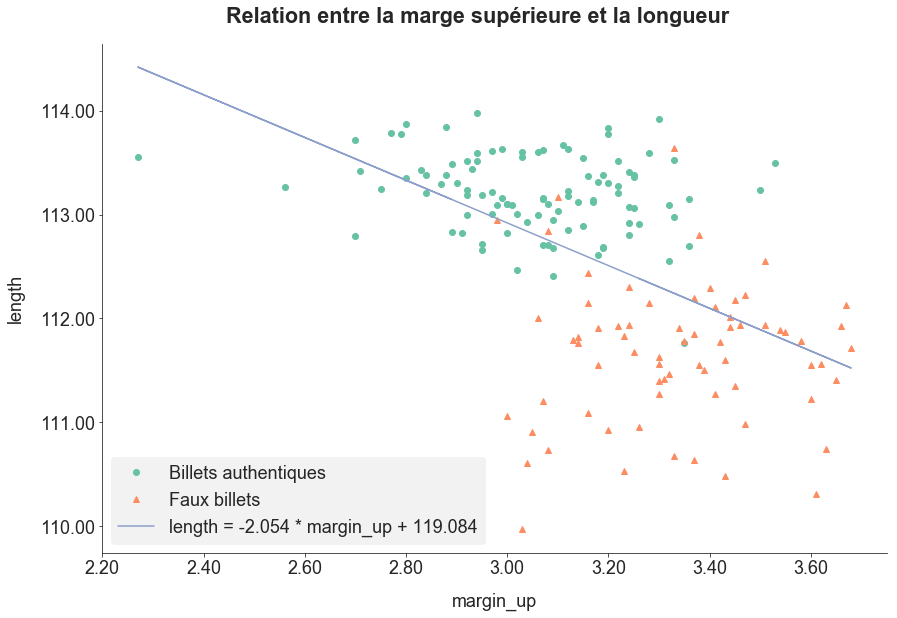

In [47]:
graph07 = sfg.MyGraph(title="Relation entre la marge supérieure et la longueur", is_mono=False)
graph07.add_plot(billets[billets.is_genuine==True][correl04.variables_retenues], billets[billets.is_genuine==True][correl04.variable_estimee], \
               label="Billets authentiques", marker='o', linestyle="")
graph07.add_plot(billets[billets.is_genuine==False][correl04.variables_retenues], billets[billets.is_genuine==False][correl04.variable_estimee], \
               label="Faux billets", marker='^', linestyle="")
graph07.add_plot(correl04.rawdata[correl04.variables_retenues], correl04.y_estimates, label=correl04.equation, legend=True)
graph07.set_axe('x', label=correl04.variables_retenues[0], tick_dash=True, tick_labels_format=':.2f')
graph07.set_axe('y', label=correl04.variable_estimee, tick_dash=True, tick_labels_format=':.2f')
fig, ax = graph07.fig, graph07.ax
plt.show()

Même chose en séparant billets authentiques et faux billets

In [48]:
correl05 = sfmr.LinearRegressionAnalysis(data=billets[billets.is_genuine==True], y_name="length", array_X_names=["margin_up"], with_standardization=False)
correl05.df_linear_correl

L'analyse a été calculée


,margin_up
length,
Personn Correlation,-0.228922
p-value - H0:r=0,0.0219662
Test result (alpha = 5%),Corrélation significative


In [49]:
correl06 = sfmr.LinearRegressionAnalysis(data=billets[billets.is_genuine==False], y_name="length", array_X_names=["margin_up"], with_standardization=False)
correl06.df_linear_correl

L'analyse a été calculée


,margin_up
length,
Personn Correlation,0.00909938
p-value - H0:r=0,0.940404
Test result (alpha = 5%),Absence de corrélation


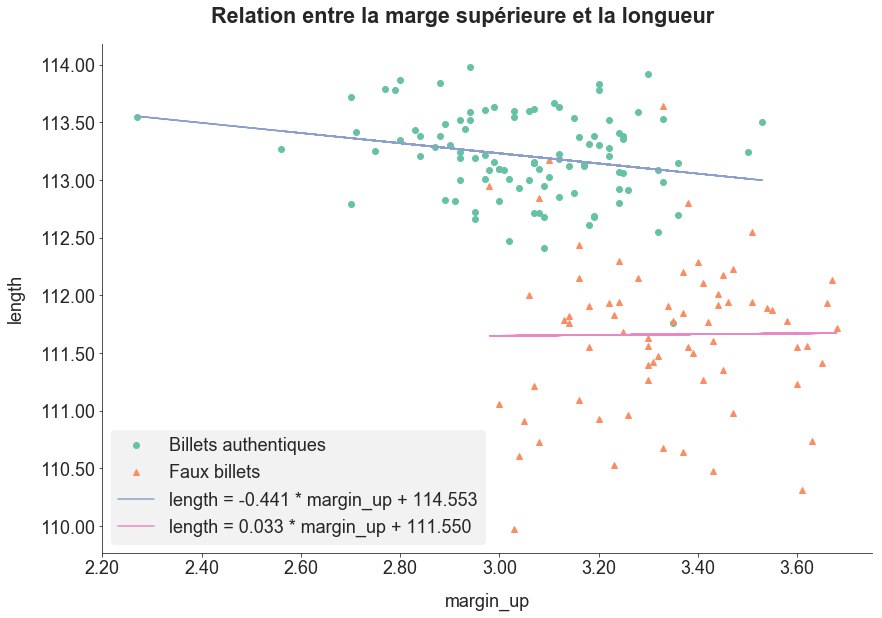

In [50]:
graph08 = sfg.MyGraph(title="Relation entre la marge supérieure et la longueur", is_mono=False)
graph08.add_plot(correl05.rawdata[correl05.variables_retenues], correl05.rawdata[correl05.variable_estimee], \
               label="Billets authentiques", marker='o', linestyle="")
graph08.add_plot(correl06.rawdata[correl06.variables_retenues], correl06.rawdata[correl06.variable_estimee], \
               label="Faux billets", marker='^', linestyle="")
graph08.add_plot(correl05.rawdata[correl05.variables_retenues], correl05.y_estimates, label=correl05.equation)
graph08.add_plot(correl06.rawdata[correl06.variables_retenues], correl06.y_estimates, label=correl06.equation, legend=True)
graph08.set_axe('x', label=correl05.variables_retenues[0], tick_dash=True, tick_labels_format=':.2f')
graph08.set_axe('y', label=correl05.variable_estimee, tick_dash=True, tick_labels_format=':.2f')
fig, ax = graph08.fig, graph08.ax
plt.show()

La corrélation entre la longueur et la marge supérieure (-0.525) est significative lorsque l'on considère tous les billets.  
La séparation des vrais billets et des faux billets ne donne pas des résultats si nets que pour la paire longueur / marge inférieure : la corrélation reste significative pour les vrais billets alors qu'elle ne l'est plus pour les faux billets.  
La paire de mesure longueur / marge inférieure paraît donc plus performante pour séparer les vrais billets des faux billets que la paire longueur / marge supérieure.

**Nos observations sur les analyses bi-variées confirment nos observations préalables. La longueur et la marge inférieure semblent être les mesures les plus pertinentes pour discrimer les vrais billets des faux billets.** Mais d'autres mesures semblent être en mesure d'apporter des informations supplémentaires pour distinguer plus finement les deux catégories de billet.

***Génération de 3 graphiques pour la présentation***

In [51]:
graph18 = sfg.MyGraph(title="", nblin=2, nbcol=1, is_mono=False, figsize=(12,12))
graph18.add_plot(billets[billets.is_genuine==True][correl04.variables_retenues], billets[billets.is_genuine==True][correl04.variable_estimee], \
               label="Billets authentiques", marker='o', linestyle="")
graph18.add_plot(billets[billets.is_genuine==False][correl04.variables_retenues], billets[billets.is_genuine==False][correl04.variable_estimee], \
               label="Faux billets", marker='^', linestyle="")
graph18.add_plot(correl04.rawdata[correl04.variables_retenues], correl04.y_estimates, label=correl04.equation, legend=True)
graph18.set_axe('x', label=correl04.variables_retenues[0], tick_dash=True, tick_labels_format=':.2f')
graph18.set_axe('y', label=correl04.variable_estimee, tick_dash=True, tick_labels_format=':.2f')
graph18.add_plot(correl05.rawdata[correl05.variables_retenues], correl05.rawdata[correl05.variable_estimee], \
               label="Billets authentiques", marker='o', linestyle="", multi_index=2)
graph18.add_plot(correl06.rawdata[correl06.variables_retenues], correl06.rawdata[correl06.variable_estimee], \
               label="Faux billets", marker='^', linestyle="", multi_index=2)
graph18.add_plot(correl05.rawdata[correl05.variables_retenues], correl05.y_estimates, label=correl05.equation, multi_index=2)
graph18.add_plot(correl06.rawdata[correl06.variables_retenues], correl06.y_estimates, label=correl06.equation, multi_index=2, legend=True)
graph18.set_axe('x', label=correl05.variables_retenues[0], tick_dash=True, tick_labels_format=':.2f', multi_index=2)
graph18.set_axe('y', label=correl05.variable_estimee, tick_dash=True, tick_labels_format=':.2f', multi_index=2)
fig, ax = graph18.fig, graph18.ax
plt.savefig("p6_m0_g06_length_marginup.png")
plt.close(fig)

In [52]:
graph19 = sfg.MyGraph(title="", nblin=2, nbcol=1, is_mono=False, figsize=(12,12))
graph19.add_plot(billets[billets.is_genuine==True][correl07.variables_retenues], billets[billets.is_genuine==True][correl07.variable_estimee], \
               label="Billets authentiques", marker='o', linestyle="")
graph19.add_plot(billets[billets.is_genuine==False][correl07.variables_retenues], billets[billets.is_genuine==False][correl07.variable_estimee], \
               label="Faux billets", marker='^', linestyle="")
graph19.add_plot(correl07.rawdata[correl07.variables_retenues], correl07.y_estimates, label=correl07.equation, legend=True)
graph19.set_axe('x', label=correl07.variables_retenues[0], tick_dash=True, tick_labels_format=':.2f')
graph19.set_axe('y', label=correl07.variable_estimee, tick_dash=True, tick_labels_format=':.2f')
graph19.add_plot(correl08.rawdata[correl08.variables_retenues], correl08.rawdata[correl08.variable_estimee], \
               label="Billets authentiques", marker='o', linestyle="", multi_index=2)
graph19.add_plot(correl09.rawdata[correl09.variables_retenues], correl09.rawdata[correl09.variable_estimee], \
               label="Faux billets", marker='^', linestyle="", multi_index=2)
graph19.add_plot(correl08.rawdata[correl08.variables_retenues], correl08.y_estimates, label=correl08.equation, multi_index=2)
graph19.add_plot(correl09.rawdata[correl09.variables_retenues], correl09.y_estimates, label=correl09.equation, multi_index=2, legend=True)
graph19.set_axe('x', label=correl08.variables_retenues[0], tick_dash=True, tick_labels_format=':.2f', multi_index=2)
graph19.set_axe('y', label=correl08.variable_estimee, tick_dash=True, tick_labels_format=':.2f', multi_index=2)
fig, ax = graph19.fig, graph19.ax
plt.savefig("p6_m0_g07_length_marginlow.png")
plt.close(fig)

In [53]:
graph20 = sfg.MyGraph(title="", nblin=2, nbcol=1, is_mono=False, figsize=(12,12))
graph20.add_plot(billets[billets.is_genuine==True][correl10.variables_retenues], billets[billets.is_genuine==True][correl10.variable_estimee], \
               label="Billets authentiques", marker='o', linestyle="")
graph20.add_plot(billets[billets.is_genuine==False][correl10.variables_retenues], billets[billets.is_genuine==False][correl10.variable_estimee], \
               label="Faux billets", marker='^', linestyle="")
graph20.add_plot(correl10.rawdata[correl10.variables_retenues], correl10.y_estimates, label=correl10.equation, legend=True)
graph20.set_axe('x', label=correl10.variables_retenues[0], tick_dash=True, tick_labels_format=':.2f')
graph20.set_axe('y', label=correl10.variable_estimee, tick_dash=True, tick_labels_format=':.2f')
graph20.add_plot(correl11.rawdata[correl11.variables_retenues], correl11.rawdata[correl11.variable_estimee], \
               label="Billets authentiques", marker='o', linestyle="", multi_index=2)
graph20.add_plot(correl12.rawdata[correl12.variables_retenues], correl12.rawdata[correl12.variable_estimee], \
               label="Faux billets", marker='^', linestyle="", multi_index=2)
graph20.add_plot(correl11.rawdata[correl11.variables_retenues], correl11.y_estimates, label=correl11.equation, multi_index=2)
graph20.add_plot(correl12.rawdata[correl12.variables_retenues], correl12.y_estimates, label=correl12.equation, multi_index=2, legend=True)
graph20.set_axe('x', label=correl11.variables_retenues[0], tick_dash=True, tick_labels_format=':.2f', multi_index=2)
graph20.set_axe('y', label=correl11.variable_estimee, tick_dash=True, tick_labels_format=':.2f', multi_index=2)
fig, ax = graph20.fig, graph20.ax
plt.savefig("p6_m0_g08_marginlow_marginup.png")
plt.close(fig)

<a id="2_0"></a>

---
## <font color=blue>2. Analyse en composantes principales (ACP)</font>

La variable is_genuine est binaire et indique si le billet est vrai ou faux. C'est une variable de résultat, pas une variable d'analyse. Par conséquent, je n'inclus pas la variable is_genuine dans l'ACP. L'ACP porte sur 6 variables et 170 individus. Elle ne peut donc pas comporter plus de 6 composantes.

<a id="2_1"></a>

### <font color=blue>2.1. Eboulis des valeurs propres</font>

J'étudie l'éboulis des valeurs propres pour estimer le nombre d'axes d'inertie à investiguer.

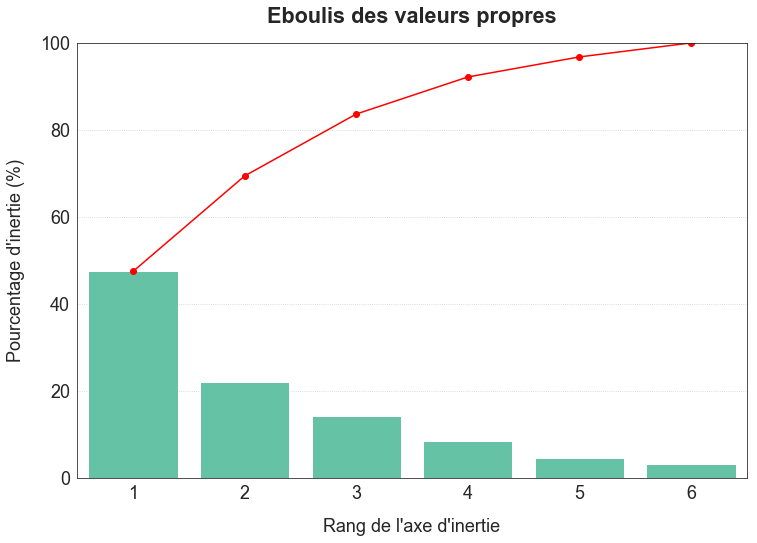

In [54]:
data_acp = billets.iloc[:,1:].copy()
n_comp = 6
acp1 = sfca.ACP(data_acp, n_comp)
fig, ax = acp1.graphique_scree_plot()
plt.savefig("p6_m1_g01_eboulis.png")
plt.show()

Le premier plan factoriel représente environ 70% de l'inertie totale. Il explique donc une grande partie de l'inertie totale, et il se peut qu'il suffise à l'analyse.  
Les quatre premiers axes d'inertie représentent plus de 90% de l'inertie totale. Il est donc inutile d'aller au delà du second plan factoriel.

<a id="2_2"></a>

### <font color=blue>2.2. Cercles des corrélations</font>

Je trace le cercle des corrélations pour les deux premiers plans factoriels afin d'interpréter les axes d'inertie.

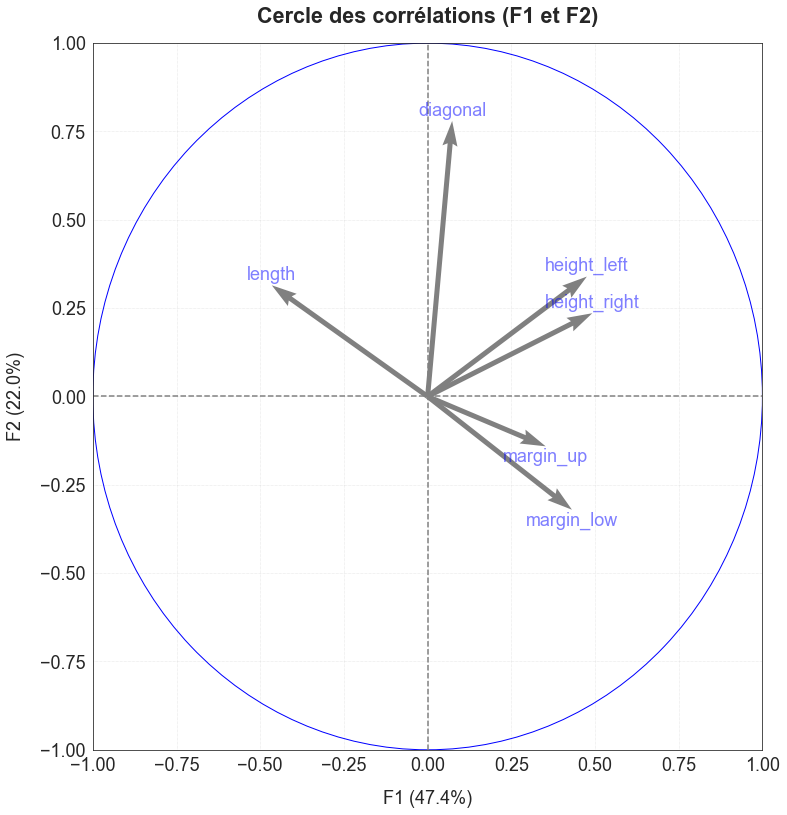

In [55]:
fig, ax = acp1.graphique_correlation_circles(axis_ranks=(0,1))
plt.savefig("p6_m1_g02_cerclecorrelationsp1.png")
plt.show()

Le premier axe d'inertie est moyennement corrélé aux hauteurs de droite et de gauche et moyennement anti-corrélé à la longueur (environ 0.50 en valeur absolue dans les trois cas). Il est également impacté, mais dans une moindre mesure, par les marges inférieures et supérieures. Il s'interprète donc comme le rapport entre les dimensions extérieures du billet, et plus précisément comme le rapport de la hauteur sur la longueur du billet.  
Le deuxième axe d'inertie est fortement corrélé (plus de 0.75) avec la diagonale. Il s'interprète donc comme la diagonale du billet.  
  
Nous retrouvons dans le premier axe d'inertie la longueur, et dans une moindre mesure la marge inférieure, qui sont les deux principales mesures qui permettent de séparer les vrais billets des faux billets.  
A contrario, le deuxième axe d'inertie est composé de la diagonale qui est la variable la moins discrimante entre les vrais et le faux billets.

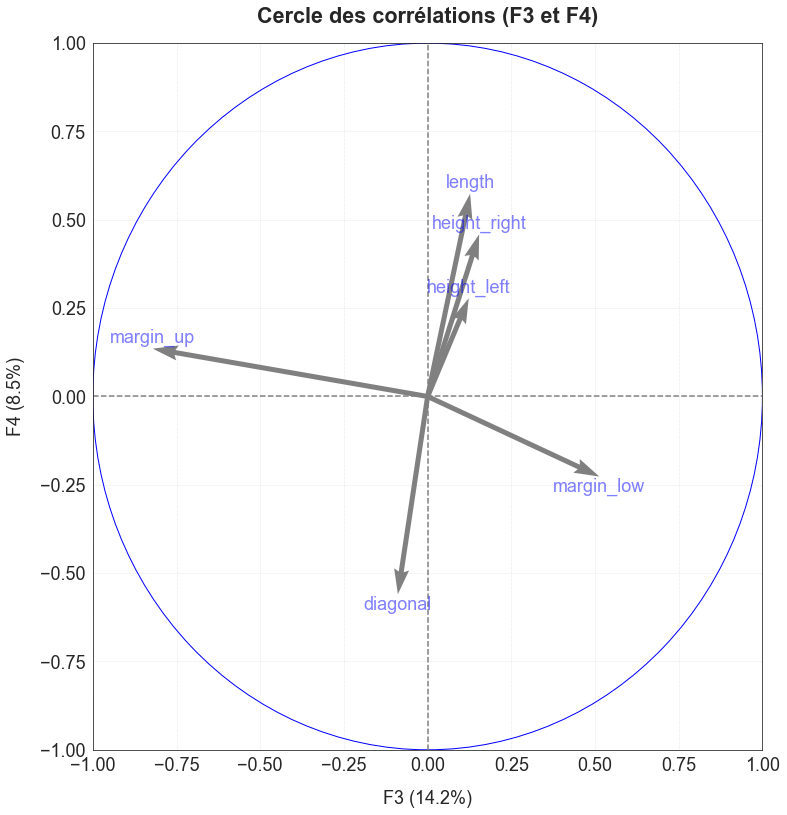

In [56]:
fig, ax = acp1.graphique_correlation_circles(axis_ranks=(2,3))
plt.savefig("p6_m1_g03_cerclecorrelationsp2.png")
plt.show()

Le troisième axe d'inertie est fortement anti-corrélé à la marge supérieure (moins de -0.80) et moyennement corrélé (environ 0.50) à la marge inférieure. Il représente donc le ratio des marges internes du billet (la marge inférieure divisée par la marge supérieure).  
Le quatrième axe d'inertie est corrélé à la longueur du billet et anti-corrélé à la diagonale du billet (environ 0.60 en valeur absolue pour ces variables). Il est également corrélé, mais moins fortement aux mesures de hauteur. Il peut donc s'interpréter comme le rapport de la longueur sur la diagonale du billet.

<a id="2_3"></a>

### <font color=blue>2.3. Projection des individus</font>

J'effectue la projection des individus sur les axes principaux d'inertie du premier et du deuxième plan factoriel afin de voir s'ils permettent de séparer efficacement les vrais billets des faux billets.

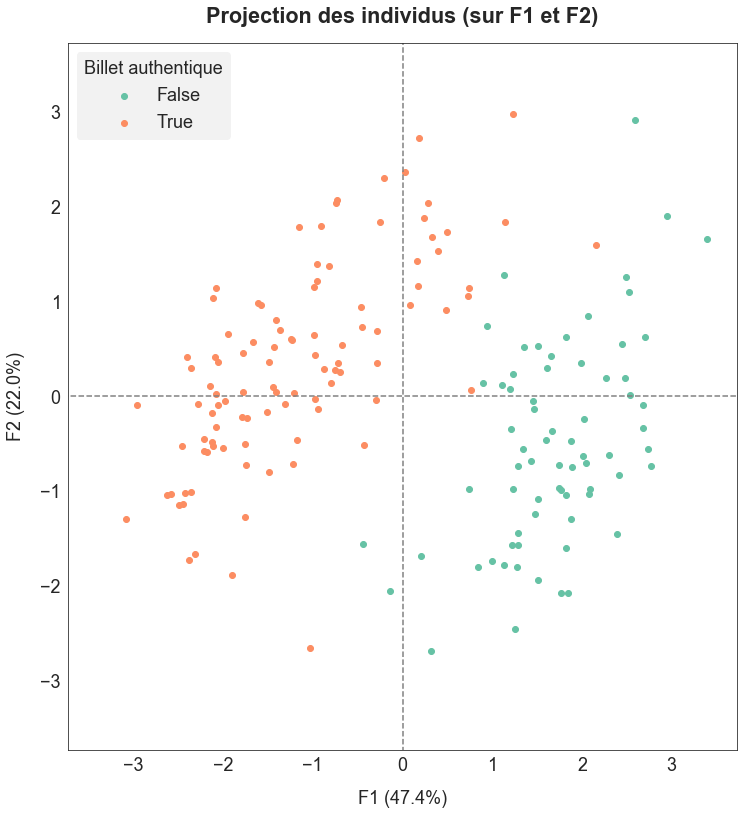

In [57]:
fig1, ax1 = acp1.graphique_factorial_planes(axis_ranks=(0,1), illustrative_var=billets.is_genuine, illustrative_legend="Billet authentique")
plt.savefig("p6_m1_g04_projectionp1.png")
plt.show()

La séparation entre les faux billets et les billets authentiques s'effectue sur le premier axe d'inertie. Les faux billets tendent à avoir un ratio hauteur sur longueur supérieur aux billets authentiques, à diagonale similaire.  
La diagonale seule ne permet pas de discriminer les faux billets et les billets authentiques. Par contre, elle est importante pour déterminer le seuil de F1 entre les vairs et les faux billets.  
Le premier plan factoriel est donc à considérer dans son ensemble : F2 est aussi important que F1 pour séparer efficacement les billets authentiques des faux billets.

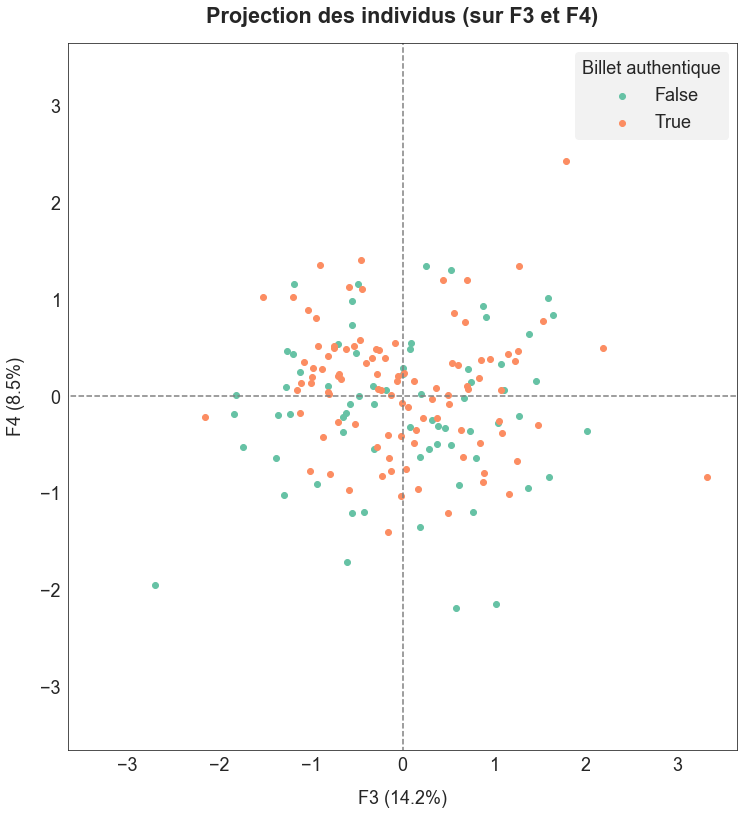

In [58]:
fig, ax = acp1.graphique_factorial_planes(axis_ranks=(2,3), illustrative_var=billets.is_genuine, illustrative_legend="Billet authentique")
plt.savefig("p6_m1_g05_projectionp2.png")
plt.show()

Le deuxième plan factoriel ne permet pas de séparer les vrais billets et les faux billets. Le ratio des marges internes et le ratio de la hauteur sur la diagonale ne permettent donc pas de discriminer les vrais billets et les faux billets.

Etant donné que les marges internes sont deux mesures qui semblent assez efficaces pour séparer les billets authentiques des faux billets lorsqu'elles sont prises individuellement, le troisième axe d'inertie peut peut-être avoir un certain intérêt, surtout qu'il représente environ 15% de l'inertie totale. Pour le vérifier, je trace les projections des individus sur le plan F1/F3 et sur le plan F2/F3.

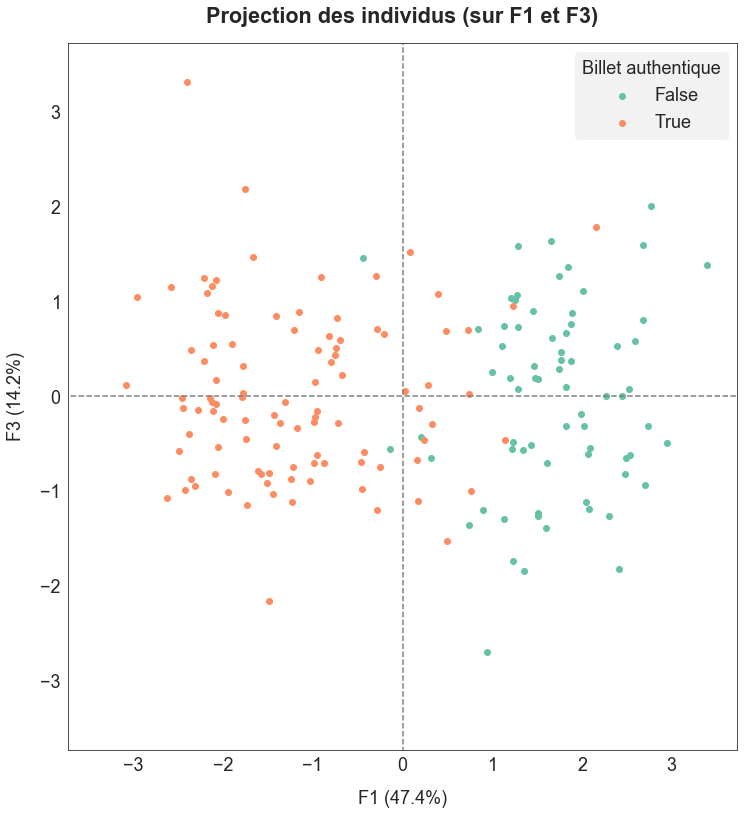

In [59]:
fig, ax = acp1.graphique_factorial_planes(axis_ranks=(0,2), illustrative_var=billets.is_genuine, illustrative_legend="Billet authentique")
plt.savefig("p6_m1_g07_projectionp13.png")
plt.show()

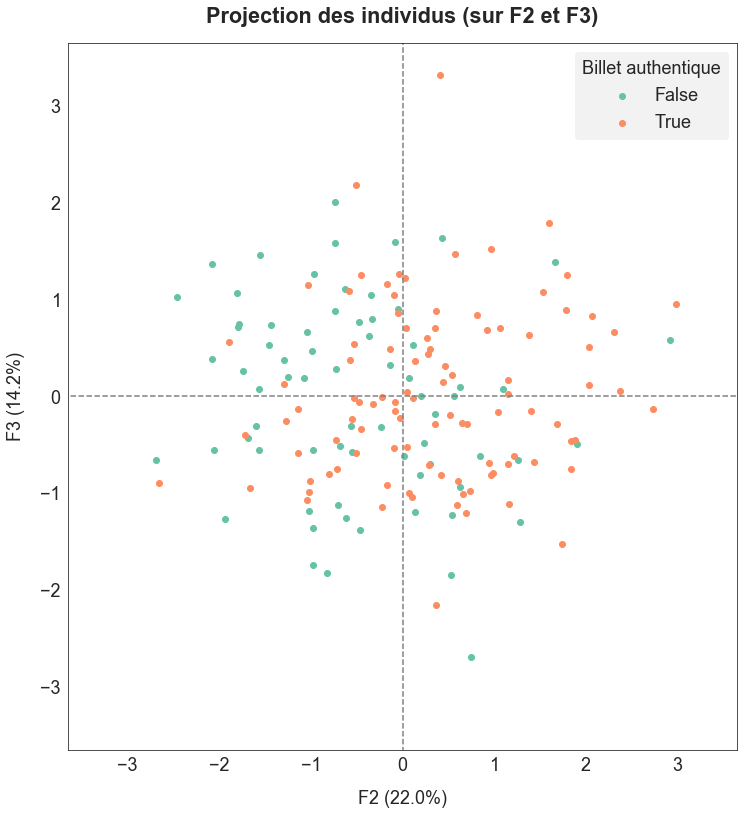

In [60]:
fig1, ax1 = acp1.graphique_factorial_planes(axis_ranks=(1,2), illustrative_var=billets.is_genuine, illustrative_legend="Billet authentique")
plt.savefig("p6_m1_g08_projectionp23.png")
plt.show()

Ces 2 graphiques confirment que le troisième axe d'inertie n'est pas utile pour séparer les vrais billets des faux billets.

In [61]:
df_cluster = billets[["is_genuine"]]
df_cluster.columns = ["cluster"]
acp1.calculate_centroids_projection(df_cluster)
acp1.df_centroids_projected.index = ["Faux billets","Billets authentiques"]
acp1.df_centroids_projected

,F1 (47.4%),F2 (22.0%),F3 (14.2%),F4 (8.5%),F5 (4.6%),F6 (3.2%)
Faux billets,1.691374,-0.502571,-0.022942,-0.139574,-0.070627,0.044398
Billets authentiques,-1.183962,0.351800,0.016060,0.097702,0.049439,-0.031079


La projection des centroïdes des faux billets et des billets authentiques confirme que la principale différenciation s'opère sur le premier axe d'inertie, à savoir sur le ratio hauteur sur longueur, avec une valeur largement supérieure pour les faux billets. Dans une moindre mesure, on constate que la diagonale des faux billets tend à être inférieure à celle des billets authentiques.  
La projection des individus sur le premier plan factoriel le montrait : ces deux valeurs sont à analyser en commun. Plus la diagonale est élevée, plus la valeur frontière entre les faux billets et les billets authentiques du ratio hauteur sur longueur est élevée.

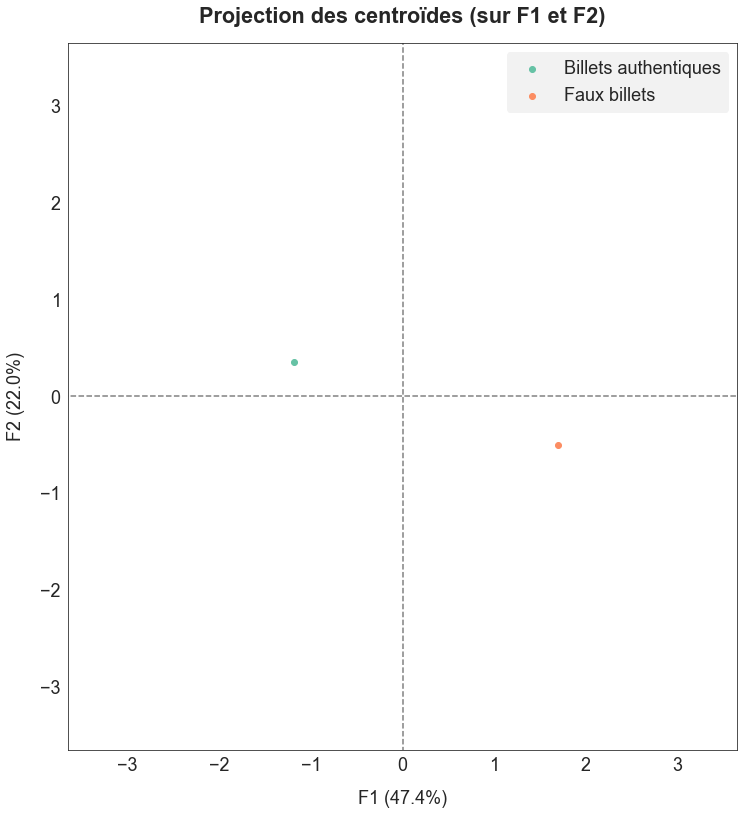

In [62]:
fig, ax = acp1.graphique_centroids_projection(illustrative_var=acp1.df_centroids_projected.index)
ax.set_xlim(ax1.get_xlim())
ax.set_ylim(ax1.get_ylim())
plt.savefig("p6_m1_g06_centroidsp1.png")
plt.show()

Je sauvegarde les données de l'ACP dans un fichier csv. Pour pouvoir les réutiliser facilement, je rajouter la colonne is_genuine.

In [63]:
acp1.df_data_projected.head()

,F1 (47.4%),F2 (22.0%),F3 (14.2%),F4 (8.5%),F5 (4.6%),F6 (3.2%)
0,2.153639,1.599709,1.787451,2.433465,0.699690,-1.267702
1,-2.110416,-0.526039,0.542563,0.344550,0.067440,-0.544601
2,-1.973152,-0.048102,0.858716,0.374812,-0.424886,0.080487
3,-2.059795,-0.089105,-0.531529,0.519548,-0.033267,-0.038261
4,-2.403180,0.412170,3.319507,-0.837043,-0.420151,-0.445099


In [64]:
data_to_save = acp1.df_data_projected.copy()
data_to_save["is_genuine"] = billets.is_genuine
data_to_save.head()

,F1 (47.4%),F2 (22.0%),F3 (14.2%),F4 (8.5%),F5 (4.6%),F6 (3.2%),is_genuine
0,2.153639,1.599709,1.787451,2.433465,0.699690,-1.267702,True
1,-2.110416,-0.526039,0.542563,0.344550,0.067440,-0.544601,True
2,-1.973152,-0.048102,0.858716,0.374812,-0.424886,0.080487,True
3,-2.059795,-0.089105,-0.531529,0.519548,-0.033267,-0.038261,True
4,-2.403180,0.412170,3.319507,-0.837043,-0.420151,-0.445099,True


In [65]:
data_to_save.to_csv("projet06_acp.csv", index_label="index")

<a id="3_0"></a>

---
## <font color=blue>3. Classification non supervisée</font>

### <font color=blue>3.1. Choix du nombre de clusters</font>

Nous devons faire une classification non supervisée sur une population de 170 individus. Nous ne savons pas combien de clusters choisir a priori. Dans un monde parfait, il y aurait 2 clusters : un comprenant les faux billets, un autre comprenant les billets authentiques. Mais il risque d'y avoir plus de 2 clusters, notamment car les faux billets peuvent avoir des spécifications différentes entre eux. Nous allons faire une classification k-means entre 2 et 20 clusters pour déterminer le nombre optimal de clusters.

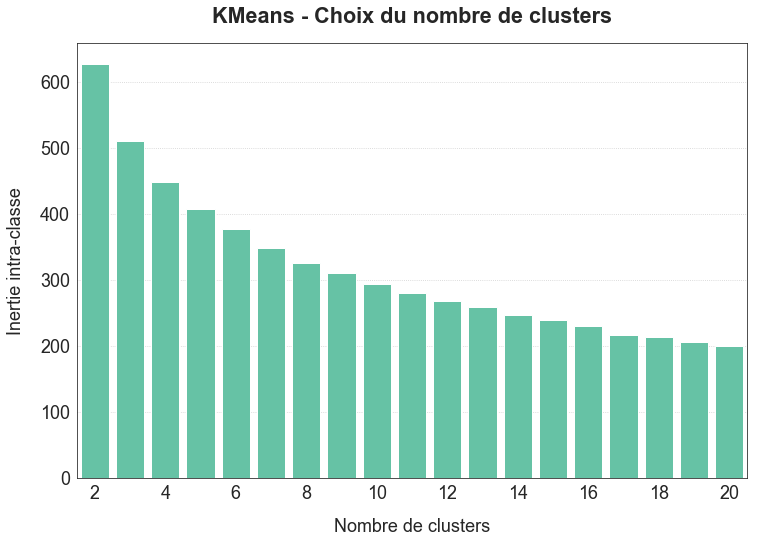

In [66]:
data_kmeans = billets.iloc[:,1:].copy()
kmeans = sfca.ClassificationKmeans(data_kmeans)
kmeans.calculate_kmeans(n_clust_min=2, n_clust_max=20, nb_essais_par_cluster=50)
fig, ax = kmeans.graphique_choix_nclusters()
plt.savefig("p6_m2_g01_nombreclusters.png")
plt.show()

Pour commencer, je teste la partition avec 2 clusters pour voir si elle permet de séparer efficacement les billets authentiques et les faux billets.  
Comme il n'y a que 2 catégories de billets (vrais et faux), je dois limiter le nombre de clusters choisis. A ce titre, je note qu'il peut être intéressant d'analyser également une partition avec 4 clusters, qui correspond au double du nombre de types possibles de billets.

<a id="3_2"></a>

### <font color=blue>3.2. K-means avec 2 clusters</font>

In [67]:
kmeans.define_n_clusters(2)
kmeans.df_centroids

,diagonal,height_left,height_right,margin_low,margin_up,length,nombre_individus
cluster 0,171.956774,103.907204,103.731183,4.139247,3.045054,113.240323,93
cluster 1,171.921039,104.258571,104.165974,5.183247,3.321818,111.761299,77


In [68]:
temp = billets.copy()
temp["cluster"] = kmeans.df_clusters
pourcentage_vrai_cluster0 = len(temp[(temp.cluster == 0) & (temp.is_genuine == True)]) / len(temp[temp.cluster == 0])
pourcentage_vrai_cluster1 = len(temp[(temp.cluster == 1) & (temp.is_genuine == True)]) / len(temp[temp.cluster == 1])
print("Pourcentage de vrais billets dans le cluster 0 = {:.2%}".format(pourcentage_vrai_cluster0))
print("Pourcentage de vrais billets dans le cluster 1 = {:.2%}".format(pourcentage_vrai_cluster1))

Pourcentage de vrais billets dans le cluster 0 = 98.92%
Pourcentage de vrais billets dans le cluster 1 = 10.39%


La partition avec 2 clusters donne d'assez bon résultats. Un cluster comporte quasiment 99% de billets authentiques (1 seul faux billet dans ce cluster de 93 billets). L'autre cluster est composé d'environ 90% de faux billets (soit 8 billets authentiques dans ce cluster de 77 billets).

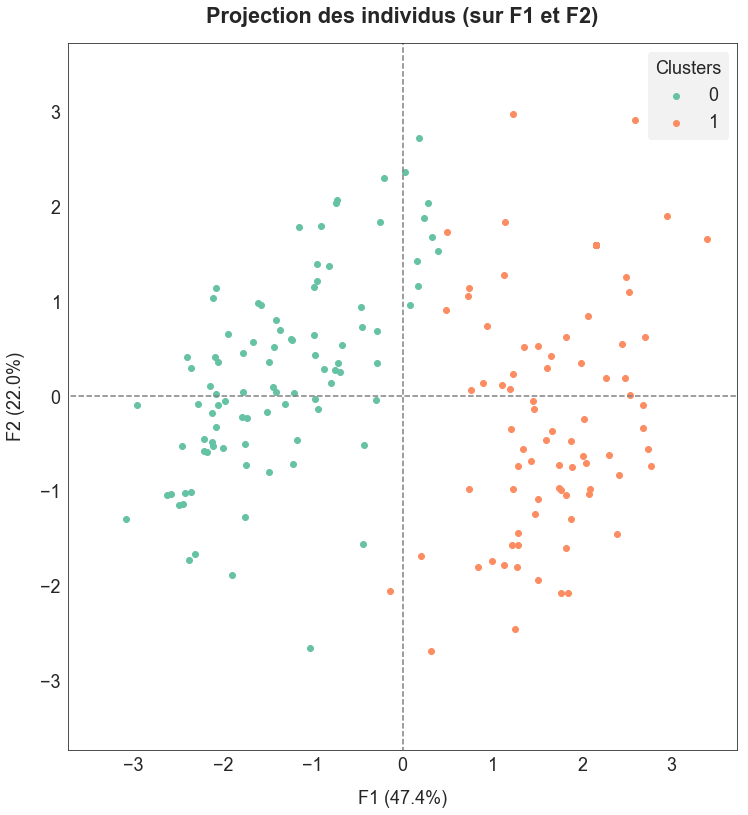

In [69]:
fig, ax = acp1.graphique_factorial_planes(axis_ranks=(0,1), illustrative_var=kmeans.df_clusters, illustrative_legend="Clusters")
plt.savefig("p6_m2_g02_projection2clusters.png")
plt.show()

Nous remarquons que la projection des clusters 0 et 1 sur le premier plan factoriel est très similaire à la projection des billets authentiques et des faux billets sur le premier plan factoriel. Cela confirme la bonne concordance entre les 2 clusters et la distinction des vrais et faux billets.  
  
Je vérifie cette bonne concordance avec une matrice de confusion.

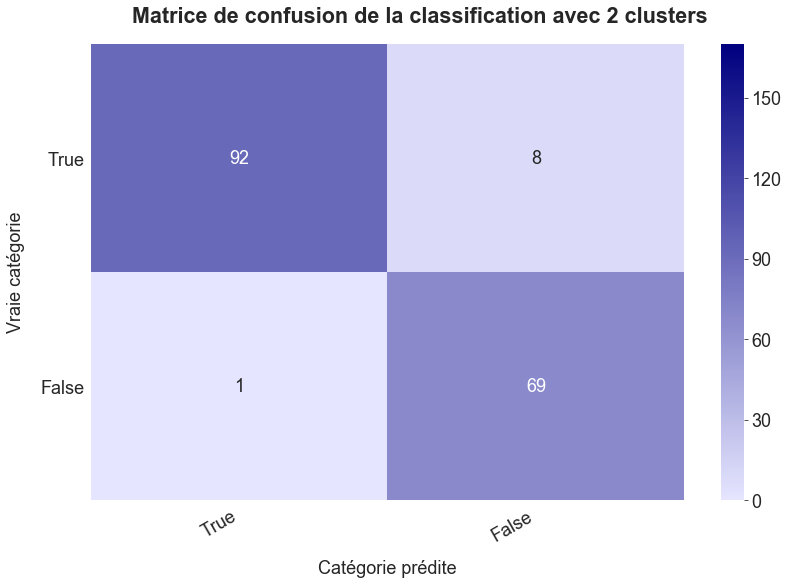

In [70]:
if pourcentage_vrai_cluster0 > 0.5:
    cluster_true = 0
else:
    cluster_true = 1
interclusters = kmeans.df_clusters == cluster_true
mc2 = sfmcs.GenericFunctions()
fig, ax = mc2.graph_confusion_matrix(billets.is_genuine, interclusters, pos_neg_labels=[True,False], title="Matrice de confusion de la classification avec 2 clusters")
plt.savefig("p6_m2_g05_confusion2clusters.png")
plt.show()

<a id="3_3"></a>

### <font color=blue>3.3. K-means avec 4 clusters</font>

Je mène maintenant l'analyse avec 4 clusters.

In [71]:
n_clusters = 4
kmeans.define_n_clusters(n_clusters)
kmeans.df_centroids

,diagonal,height_left,height_right,margin_low,margin_up,length,nombre_individus
cluster 0,171.856212,103.786818,103.636061,4.088333,3.030758,113.245606,66
cluster 1,172.075588,104.297059,104.235000,4.877353,3.453824,111.652941,34
cluster 2,171.720541,104.165946,104.063784,5.620541,3.225405,111.670541,37
cluster 3,172.216970,104.276061,104.043939,4.255758,3.096061,113.174242,33


In [72]:
temp = billets.copy()
temp["cluster"] = kmeans.df_clusters
pourcentage_vrai_cluster = []
for i in np.arange(n_clusters):
    pourcentage_vrai_cluster.append(len(temp[(temp.cluster == i) & (temp.is_genuine == True)]) / len(temp[temp.cluster == i]))
for i in np.arange(n_clusters):
    print("Pourcentage de vrais billets dans le cluster {} = {:.2%}".format(i, pourcentage_vrai_cluster[i]))

Pourcentage de vrais billets dans le cluster 0 = 100.00%
Pourcentage de vrais billets dans le cluster 1 = 2.94%
Pourcentage de vrais billets dans le cluster 2 = 0.00%
Pourcentage de vrais billets dans le cluster 3 = 100.00%


La partition avec 4 clusters est très efficace :  
- 2 clusters ne comportent que des billets authentiques ;  
- un cluster ne contient que des faux billets ;  
- un cluster contient environ 97% de faux billets (un seul billet authentique est mal classé dans ce cluster).

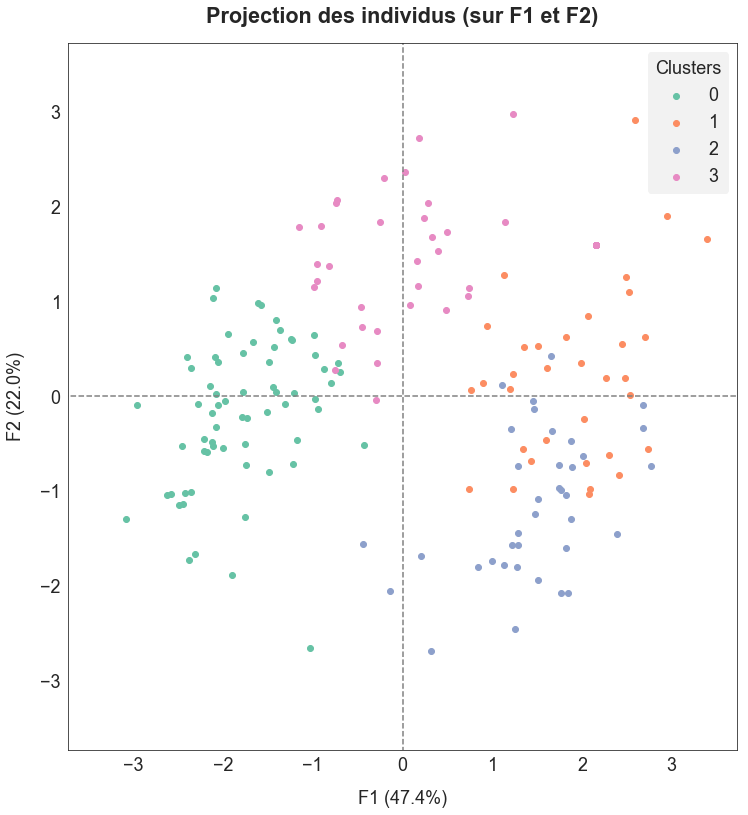

In [73]:
fig, ax = acp1.graphique_factorial_planes(axis_ranks=(0,1), illustrative_var=kmeans.df_clusters, illustrative_legend="Clusters")
plt.savefig("p6_m2_g03_projection4clusters.png")
plt.show()

Cette partition avec 4 clusters crée 2 groupes à l'intérieur des faux billets et des vrais billets sur la base de la longueur de leur diagonale, en séparant les billets dont la diagonale est faible et ceux dont la diagonale est élevée.

Je génère la matrice de confusion de la classification avec 4 clusters, pour vérifier son efficacité.

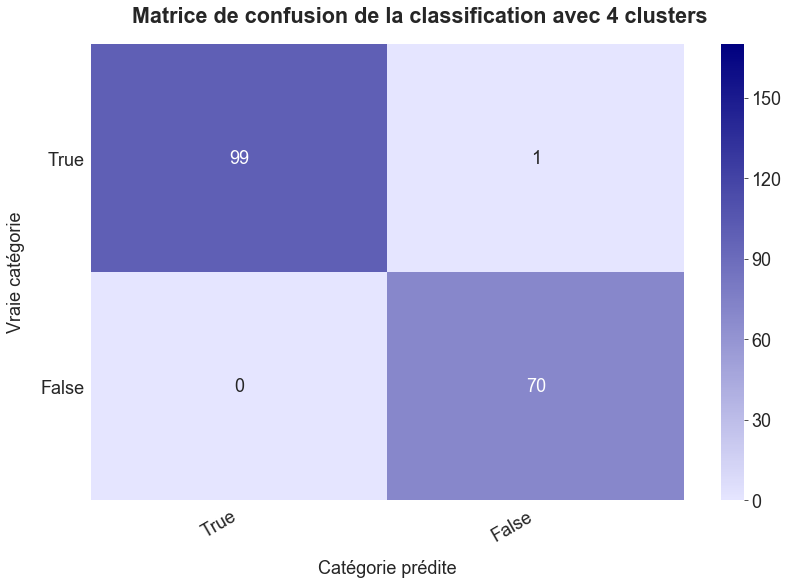

In [74]:
clusters_true = []
for i in np.arange(n_clusters):
    if pourcentage_vrai_cluster[i] > 0.5:
        clusters_true.append(i)
interclusters = np.isin(kmeans.df_clusters, clusters_true)
mc4 = sfmcs.GenericFunctions()
fig, ax = mc4.graph_confusion_matrix(billets.is_genuine, interclusters, pos_neg_labels=[True,False], title="Matrice de confusion de la classification avec 4 clusters")
plt.savefig("p6_m2_g06_confusion4clusters.png")
plt.show()

<a id="4_0"></a>

---
## <font color=blue>4. Modélisation par une régression logistique</font>

Je réalise deux études pour la régression logistique :  
- la première est basée sur les données de la base billets ;  
- la deuxième est basée sur les données de l'ACP.

<a id="4_1"></a>

### <font color=blue>4.1. Régression logistique basée sur les données brutes de la base billets</font>

Je sépare les données en deux groupes : entraînement et test.

In [75]:
data_brutes = sfmcs.TrainTestData(save_name="traintest_billets_brut.csv", data=billets, y_name='is_genuine')

Train-test split existant chargé


#### <font color=blue>4.1.1. Analyse et sélection du modèle sur les données d'entraînement</font>

**Toutes les variables**

J'effectue une première régression logistique basée sur toutes les variables disponibles. Puis j'étudie les résultats pour voir les actions à entreprendre.

In [76]:
reg1 = sfmcs.LogisticRegressionAnalysis(data=data_brutes.train, y_name='is_genuine', array_X_names=billets.columns[1:])

L'analyse a été calculée


                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                  127
Model:                          Logit   Df Residuals:                      120
Method:                           MLE   Df Model:                            6
Date:                Fri, 23 Aug 2019   Pseudo R-squ.:                   1.000
Time:                        18:38:05   Log-Likelihood:             -0.0015794
converged:                       True   LL-Null:                       -85.935
                                        LLR p-value:                 1.806e-34
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            9.5111    348.698      0.027      0.978    -673.925     692.947
diagonal         2.2503   2709.605      0.001      0.999   -5308.477    5312.978
height_left     -4.9873   2661.911     -0.00

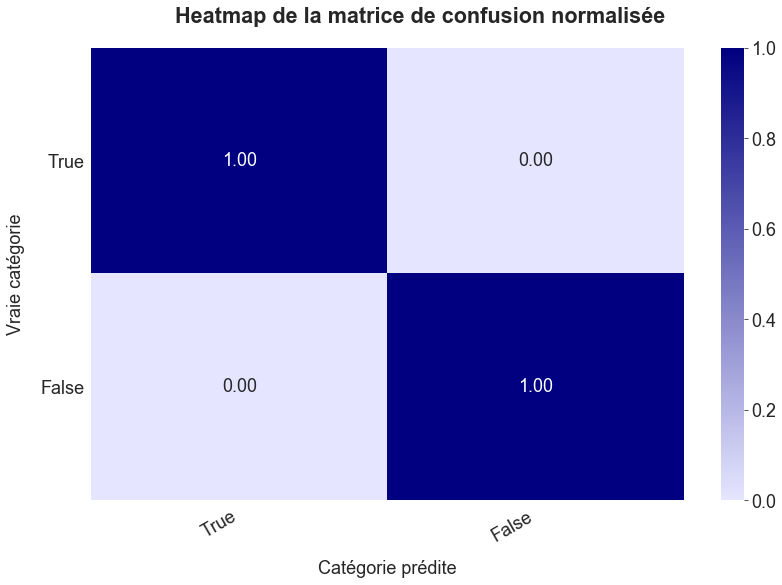

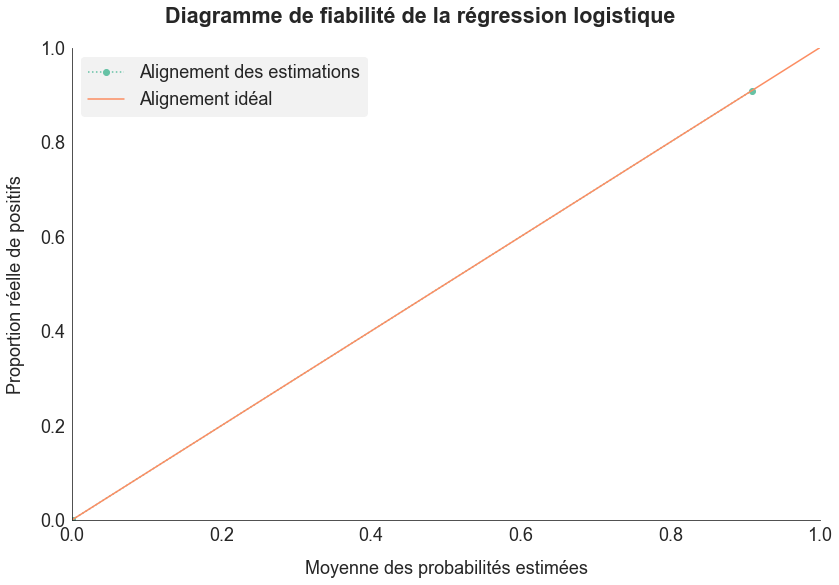

In [77]:
reg1.print_resultats()

In [78]:
fig, ax = reg1.graph_confusion_matrix(y_true=reg1.y, y_pred=reg1.df_y_estimates.binaire, pos_neg_labels=reg1.pos_neg_labels)
plt.savefig("p6_m3_g02_directfull_heatmap.png")
plt.close(fig)

In [79]:
reg1.print_analyse_observations(graphs=False)

RAPPEL DES SEUILS
levier residus_pearson residus_pearson_standard   cook
 0.110           1.960                    1.960  0.033

RÉSUMÉ DES OBSERVATIONS ATYPIQUES ET INFLUENTES
Ces variables sont à investiguer : elles sont atypiques et pèsent sur la régression
Empty DataFrame
Columns: [observation_name, levier, residus_pearson, residus_pearson_standard, outlier, cook_distance, influence]
Index: []


Il n'y a pas d'observations à la fois atypiques et influentes.

La régression logistique est sur-optimisée lorsqu'on intègre toutes les variables : les p-values de tous les coefficients sont proches de 1 et la séparation est parfaite. On ne peut pas garder ce modèle.

**Sélection automatique de variables**

J'effectue deux sélections de variables sur la base des critères AIC et BIC pour les comparer. J'ai choisi ces deux critères plutôt que les p-values des coefficients car mon modèle a un but prédictif. Dans ce cas, l'AIC ou le BIC sont les critères les plus pertinents. Ils sont assez similaires mais le BIC privilégie les modèles avec moins de variables explicatives.

In [80]:
reg1.forward_selection_prediction(bic=False)

Sélection forward basée sur le critère AIC
Variable ajoutée : length (AIC = 56.985).

Variable ajoutée : margin_low (AIC = 14.519).

Variable ajoutée : margin_up (AIC = 8.016).

Modèle intermédiaire atteint : meilleur AIC obtenu.

Sélection backward à partir des variables sélectionnées, pour vérifier d'éventuels effets croisés
Modèle final atteint : meilleur AIC obtenu.

Variables explicatives : length, margin_low, margin_up, constante
AIC du modèle = 8.015653
L'analyse a été calculée


In [81]:
reg1.forward_selection_prediction(bic=True)

Sélection forward basée sur le critère BIC
Variable ajoutée : length (BIC = 62.673).

Variable ajoutée : margin_low (BIC = 23.052).

Variable ajoutée : margin_up (BIC = 19.392).

Modèle intermédiaire atteint : meilleur BIC obtenu.

Sélection backward à partir des variables sélectionnées, pour vérifier d'éventuels effets croisés
Modèle final atteint : meilleur BIC obtenu.

Variables explicatives : length, margin_low, margin_up, constante
BIC du modèle = 19.392402
L'analyse a été calculée


La sélection automatique de variables conserve les 3 variables length, margin_low et margin_up, que ce soit avec l'AIC ou le BIC comme critère.  
  
Analysons les résultats obtenus par le modèle de régression logistique basé sur ces 3 variables.

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                  127
Model:                          Logit   Df Residuals:                      123
Method:                           MLE   Df Model:                            3
Date:                Fri, 23 Aug 2019   Pseudo R-squ.:                  0.9999
Time:                        18:38:07   Log-Likelihood:             -0.0078267
converged:                       True   LL-Null:                       -85.935
                                        LLR p-value:                 5.060e-37
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3711     52.485      0.179      0.858     -93.497     112.239
length        16.7224     58.109      0.288      0.774     -97.168     130.613
margin_low   -39.5802     79.503     -0.498      0.6

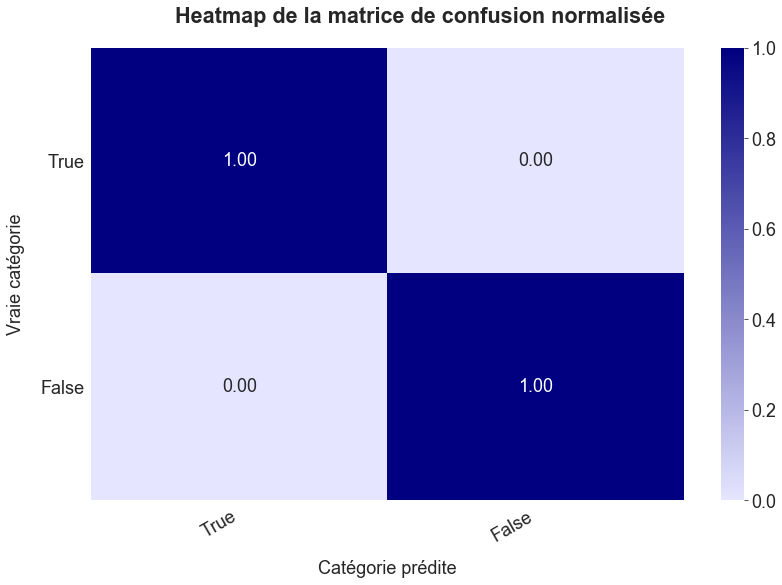

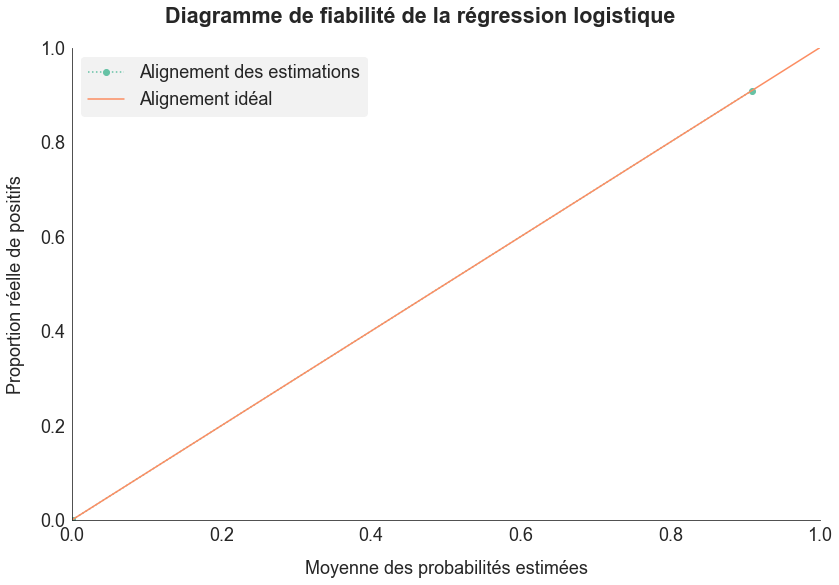

In [82]:
reg1.print_resultats()

In [83]:
fig, ax = reg1.graph_confusion_matrix(y_true=reg1.y, y_pred=reg1.df_y_estimates.binaire, pos_neg_labels=reg1.pos_neg_labels)
plt.savefig("p6_m3_g05_direct3_heatmap.png")
plt.close(fig)

Ce modèle n'est pas satisfaisant : la p-value de tous les coefficients est proche de 1 (ils ne sont pas significatifs) et le modèle réalise une séparation parfaite. Il y a encore une sur-optimisation.

**Modèle avec 2 variables : length et margin_low**

Je fais un dernier essai en ne conservant que les deux variables sélectionnées en premier par l'AIC et le BIC : length et margin_low. Cette sélection est logique car notre analyse univariée avait montré que ces deux variables sont les plus discrimantes. De plus, nous avons vu qu'elles ne sont pas corrélées lorsque l'on traite séparément les vrais billets et les faux billets. Je retire donc margin_up.

In [84]:
reg1.remove_from_variables_retenues("margin_up")

L'analyse a été calculée


                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                  127
Model:                          Logit   Df Residuals:                      124
Method:                           MLE   Df Model:                            2
Date:                Fri, 23 Aug 2019   Pseudo R-squ.:                  0.9504
Time:                        18:38:09   Log-Likelihood:                -4.2596
converged:                       True   LL-Null:                       -85.935
                                        LLR p-value:                 3.378e-36
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8688      0.998      0.870      0.384      -1.088       2.825
length         7.7768      3.239      2.401      0.016       1.428      14.125
margin_low    -9.1552      3.821     -2.396      0.0

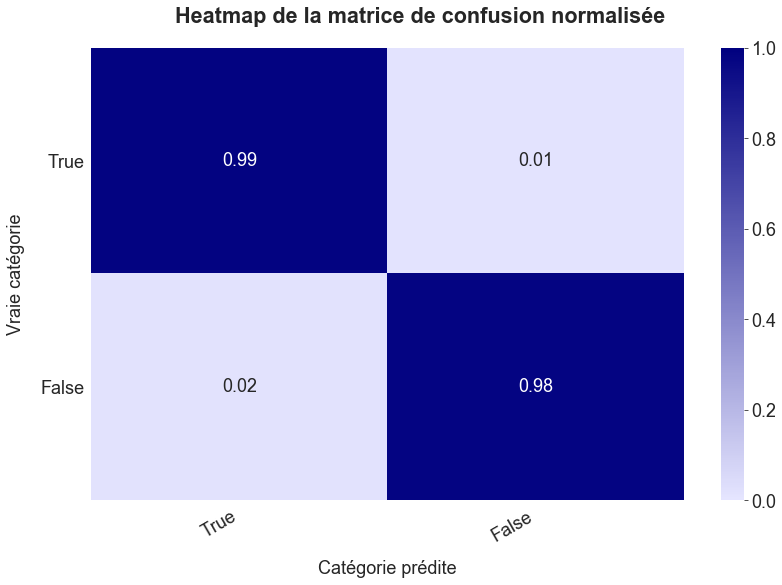

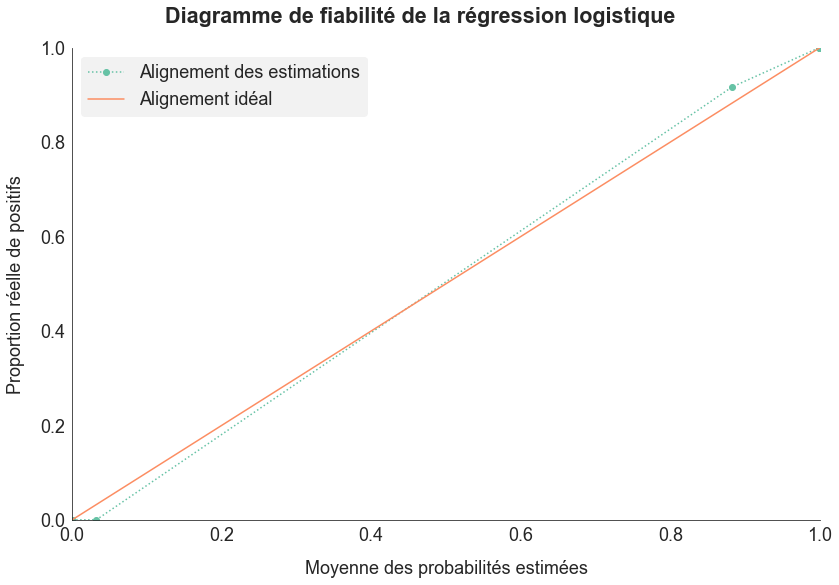

In [85]:
reg1.print_resultats()

In [86]:
fig, ax = reg1.graph_confusion_matrix(y_true=reg1.y, y_pred=reg1.df_y_estimates.binaire, pos_neg_labels=reg1.pos_neg_labels)
plt.savefig("p6_m3_g07_direct2_heatmap.png")
plt.close(fig)

J'obtiens un modèle qui converge, avec des coefficients significatifs au seuil de 5%. La matrice de confusion montre de très bons résultats, sans que la classification soit parfaite.  
Je garde cette sélection de deux variables.  
  
J'analyse les observations.

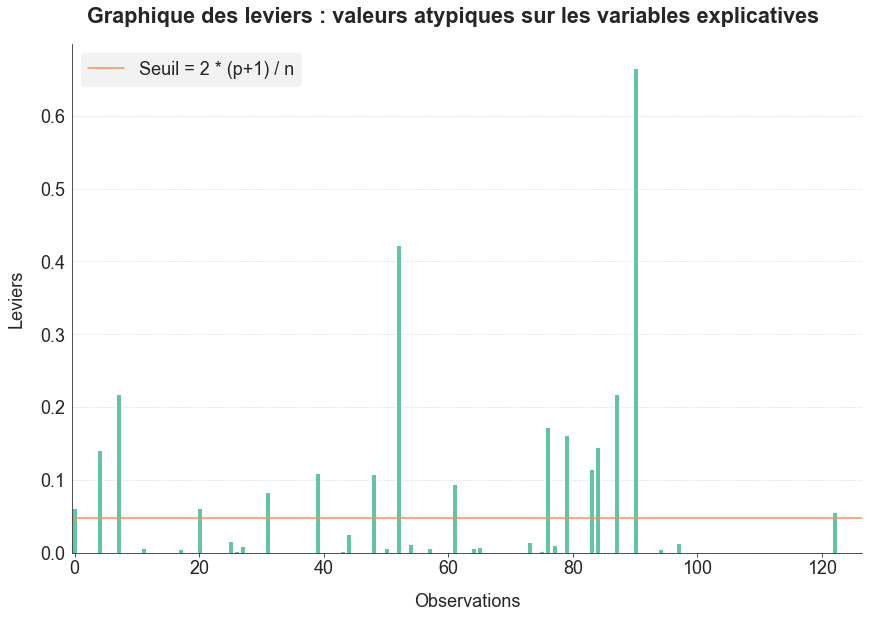

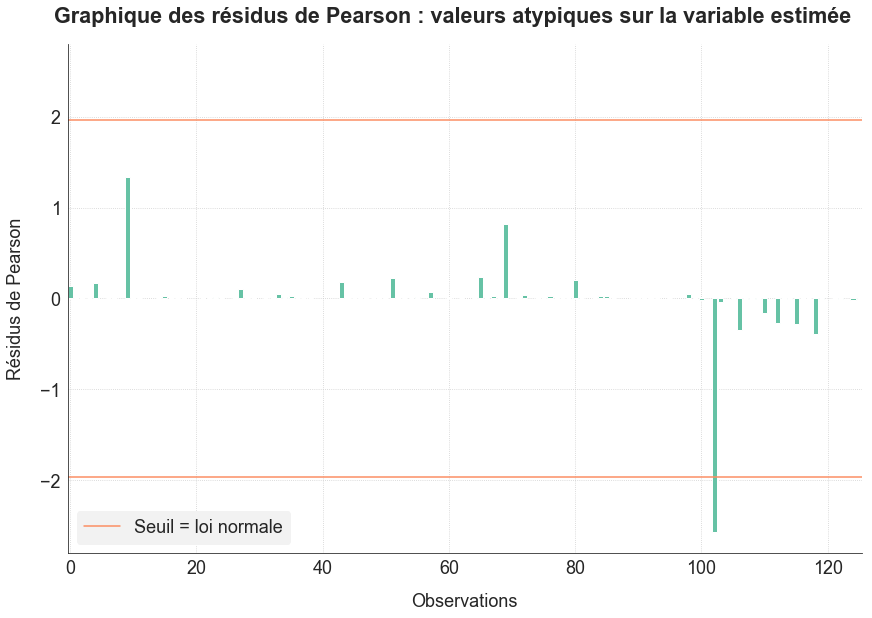

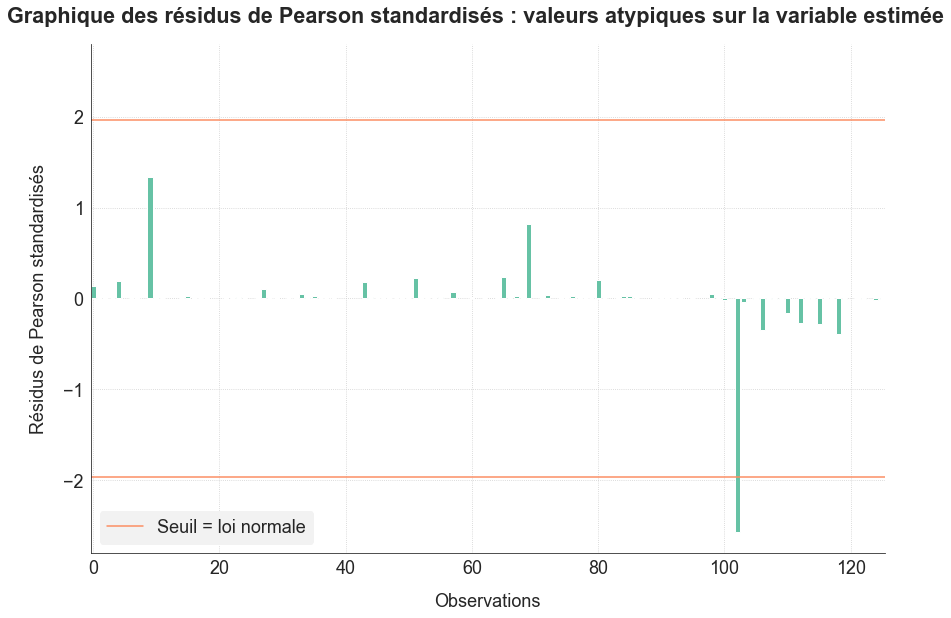

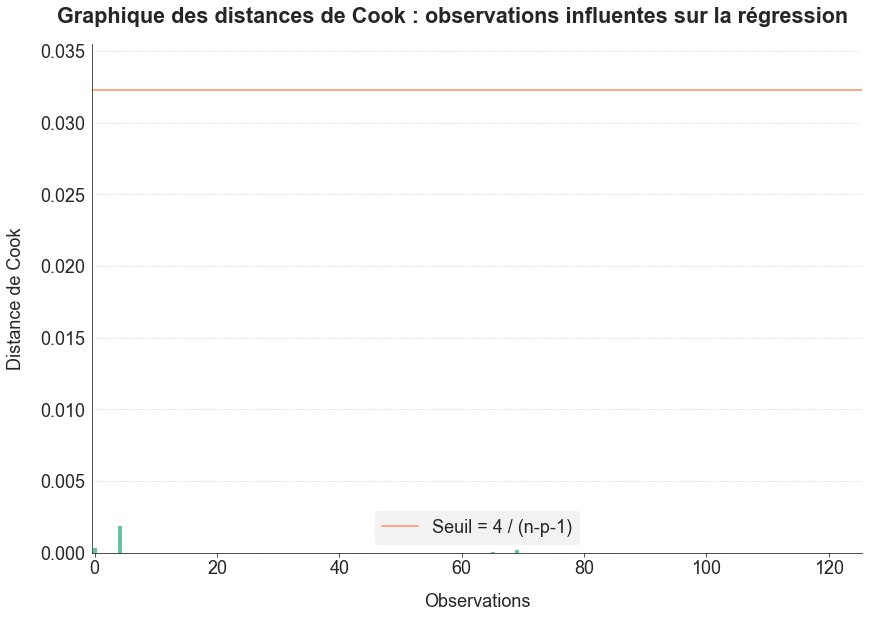


RAPPEL DES SEUILS
levier residus_pearson residus_pearson_standard   cook
 0.047           1.960                    1.960  0.032

RÉSUMÉ DES OBSERVATIONS ATYPIQUES OU INFLUENTES
     observation_name levier residus_pearson residus_pearson_standard  \
0                   0  0.062           0.136                    0.141   
4                   4  0.141           0.176                    0.189   
7                   9  0.217           0.000                    0.000   
20                 27  0.061             nan                      nan   
31                 43  0.083           0.001                    0.001   
39                 51  0.109             nan                      nan   
48                 65  0.109           0.003                    0.004   
52                 69  0.423           0.003                    0.004   
61                 80  0.094             nan                      nan   
76                102  0.173           0.025                    0.028   
79                1

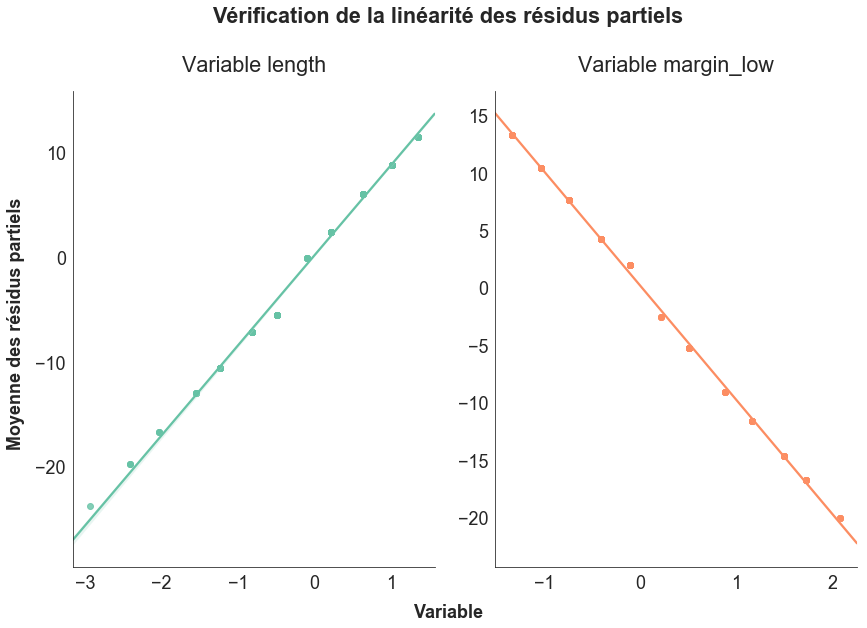

In [87]:
reg1.print_analyse_observations()

RAS sur les observations : quelques observations atypiques mais aucune n'est influente.  
Le graphique des résidus partiels confirme l'extrême linéarité des résidus partiels, qui explique la quasi-perfection du modèle. Les 2 variables exogènes ont une relation forte avec la variable binaire endogène.

Avec un échantillon de 127 observations, le respect des critères de normalité sur les résidus est moins important. J'analyse quand même les résidus, pour information.

NORMALITÉ DES RÉSIDUS

Test de Shapiro : p-value = 0.000.
L'hypothèse de normalité des résidus est rejetée.

Test de Jarque-Bera : p-value = 0.000.
L'hypothèse de normalité des résidus est rejetée.

Comme il y a plus de 30 observations (127), on peut accepter la normalité si la distribution est à peu près symétrique.



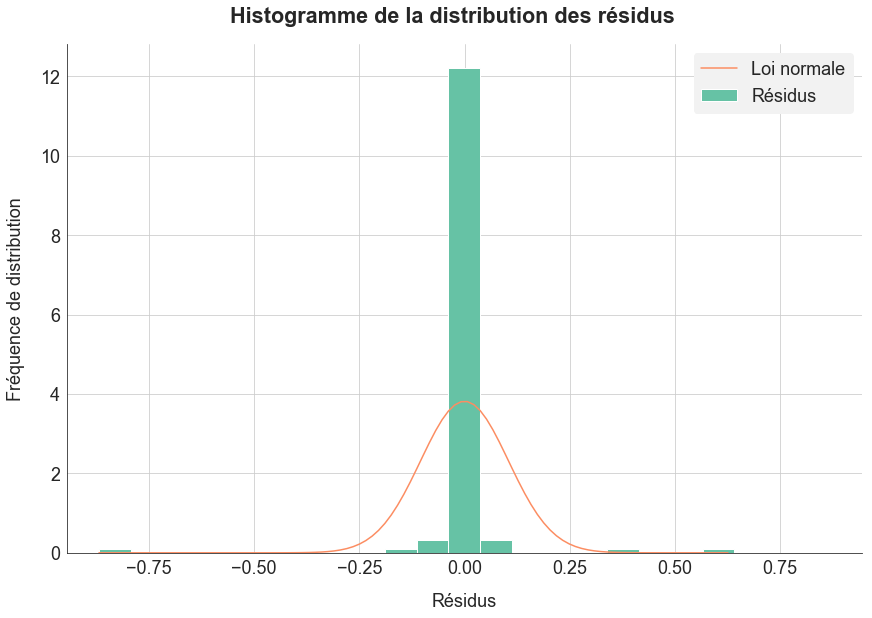

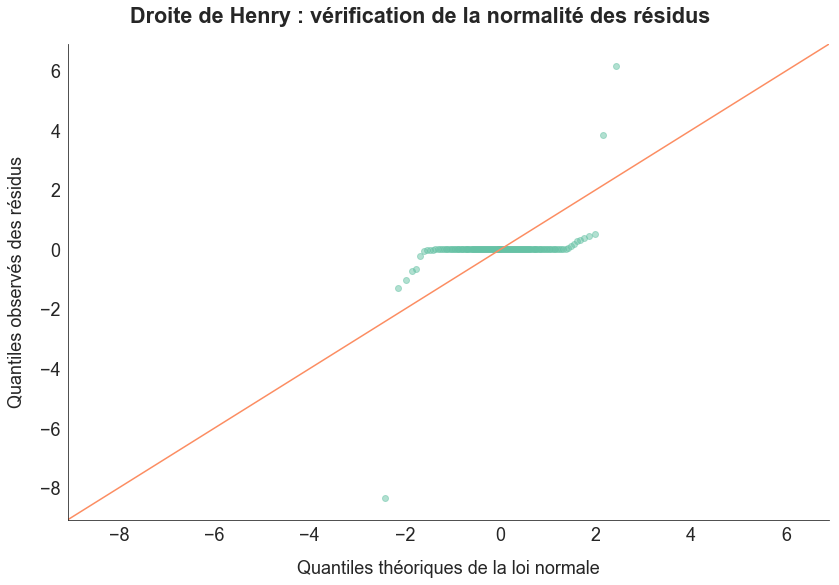


HOMOSCEDASTICITÉ DES RÉSIDUS

Dans le cadre de la régression logistique, la variance de l'erreur (= proba_estimee * (1-proba_estimee)) dépend des individus. Il y a hétéroscédasticité.



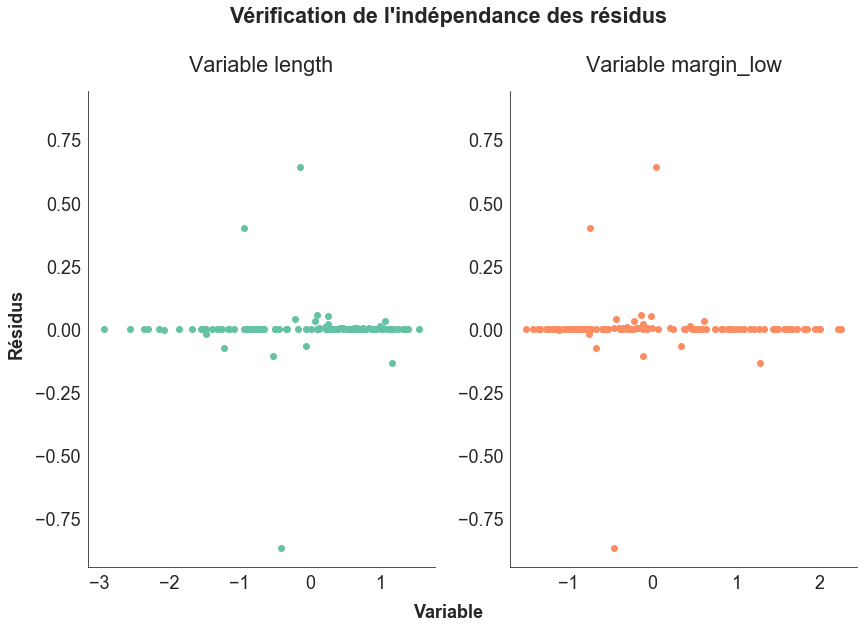

In [88]:
reg1.print_analyse_residus()

L'histogramme de la distribution des résidus montre qu'ils sont à peu près normaux, bien qu'il y ait une sur-représentation des résidus nuls, due à la quasi-perfection du modèle.  
Le graphique des résidus montre cette quasi-perfection du modèle avec une immense majorité des résidus égaux à 0.

ANALYSE DE LA COLINÉARITÉ SIMPLE
Les valeurs de la matrice de corrélation doivent être inférieures à 0.8


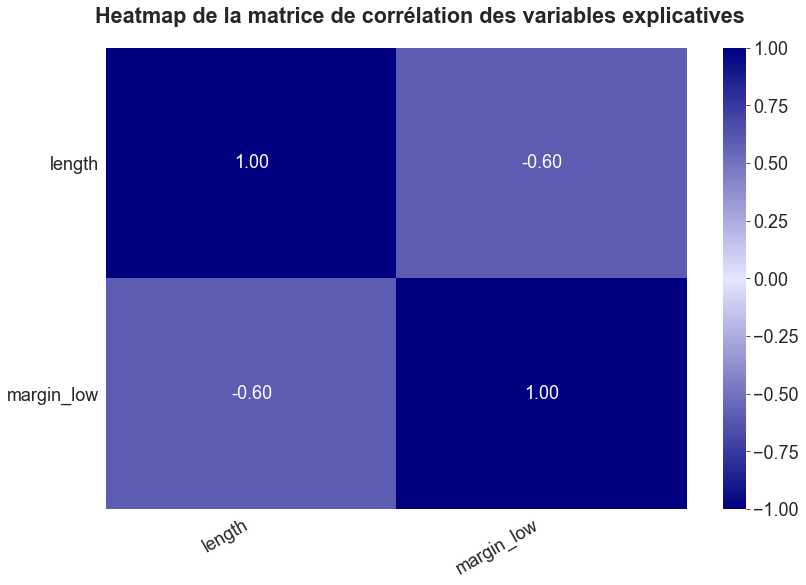


ANALYSE DE LA MULTI-COLINÉARITÉ
L'indice VIF doit être inférieur à 4
              VIF
length      1.565
margin_low  1.565


In [89]:
reg1.print_analyse_colinearite()

In [90]:
fig, ax = reg1.graph_heatmap_correlationmatrix()
plt.savefig("p6_m3_g08_direct2_correlation.png")
plt.close(fig)

Pas de problème de linéarité simple ou de colinéarité.

<a id="4_1_2"></a>

#### <font color=blue>4.1.2. Validation croisée du modèle</font>

Je vérifie la robustesse du modèle par cross-validation sur le groupe de données d'entraînement, puis en calculant le score sur le groupe de données de test.

In [91]:
check1 = sfmcs.LogisticRegressionPrediction(data=reg1.rawdata, y_name=reg1.variable_estimee, array_X_names=reg1.variables_retenues)

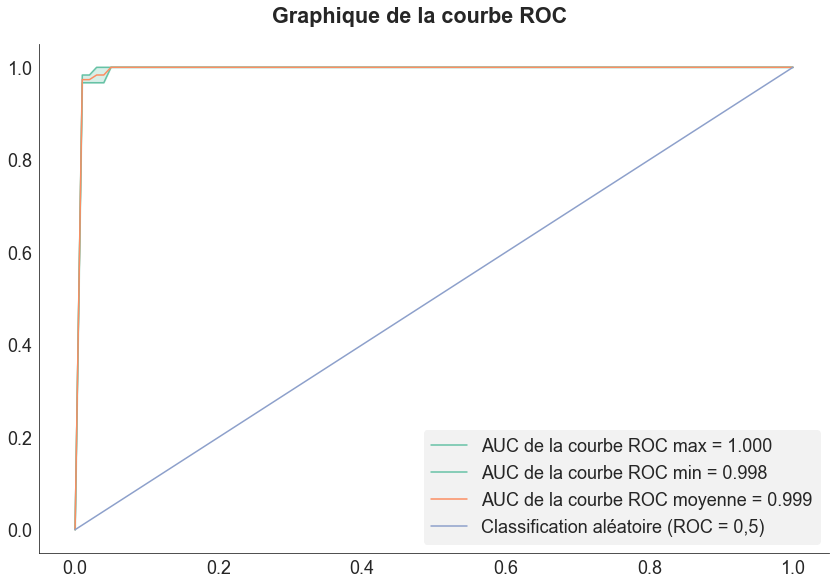

,0,1,2,3,4,moyenne,ecart_type
taux_succes,0.923077,0.961538,1.0,0.960000,1.0,0.968923,0.032278
f_mesure,0.937500,0.967742,1.0,0.965517,1.0,0.974152,0.026435
auc,0.993939,1.000000,1.0,1.000000,1.0,0.998788,0.002710
precision_rappel_score,0.995833,1.000000,1.0,1.000000,1.0,0.999167,0.001863


In [92]:
cv_results, fig, ax = check1.cross_validation()
plt.savefig("p6_m3_g09_direct2_crossvalidation.png")
plt.show()
cv_results

<a id="4_1_3"></a>

#### <font color=blue>4.1.3. Vérification sur les données de test</font>

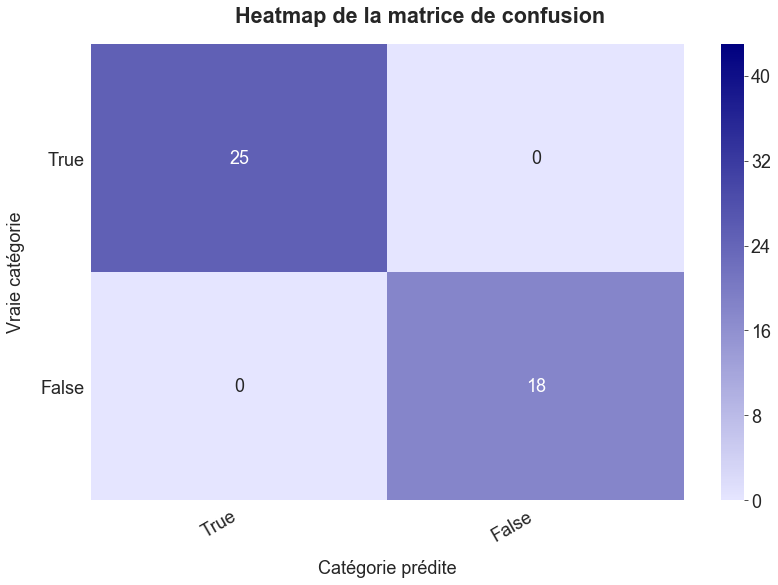

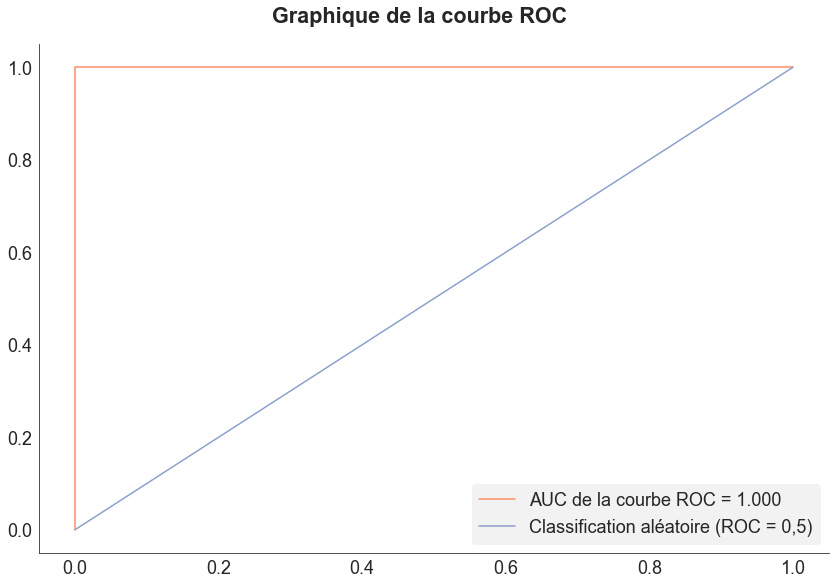

taux_succes               1.0
f_mesure                  1.0
auc                       1.0
precision_rappel_score    1.0


In [93]:
scores, fig_cm, ax_cm, fig_roc, ax_roc = check1.calcul_score_prediction(data_input=data_brutes.test, true_y=data_brutes.test[check1.variable_estimee])
fig_cm.savefig("p6_m3_g10_direct2_test_matriceconfusion.png")
fig_roc.savefig("p6_m3_g11_direct2_test_roccurve.png")
plt.show()
print(scores.to_string())

La validation croisée sur les données d'entraînement donne des résultats excellents, avec des mesures toutes supérieures à 0.96.  
Les données de test confirment les bons résultats du modèle en obtenant une séparation parfaite des données.  
Ce modèle peut-être utilisé à des fins de prédiction.

Je sauvegarde la standardisation et le modèle avec joblib. Pour cela, je crée un objet spécifique LogisticRegressionProduction().

In [94]:
direct_reg = sfmcs.ProductionLogisticRegression(check1.variable_estimee, check1.variables_explicatives, \
        check1.scaler, check1.with_constant, check1.method, check1.model, check1.classification)

In [95]:
joblib.dump(direct_reg, "direct_logreg.joblib")

['direct_logreg.joblib']

<a id="4_2"></a>

### <font color=blue>4.2. Régression logistique basée sur les données de l'ACP</font>

Je charge les données de l'ACP et je les sépare en deux groupes : entraînement et test.

In [96]:
inter_data = pd.read_csv("projet06_acp.csv", index_col="index")
inter_data.head()

,F1 (47.4%),F2 (22.0%),F3 (14.2%),F4 (8.5%),F5 (4.6%),F6 (3.2%),is_genuine
index,,,,,,,
0,2.153639,1.599709,1.787451,2.433465,0.699690,-1.267702,True
1,-2.110416,-0.526039,0.542563,0.344550,0.067440,-0.544601,True
2,-1.973152,-0.048102,0.858716,0.374812,-0.424886,0.080487,True
3,-2.059795,-0.089105,-0.531529,0.519548,-0.033267,-0.038261,True
4,-2.403180,0.412170,3.319507,-0.837043,-0.420151,-0.445099,True


In [97]:
inter_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 0 to 169
Data columns (total 7 columns):
F1 (47.4%)    170 non-null float64
F2 (22.0%)    170 non-null float64
F3 (14.2%)    170 non-null float64
F4 (8.5%)     170 non-null float64
F5 (4.6%)     170 non-null float64
F6 (3.2%)     170 non-null float64
is_genuine    170 non-null bool
dtypes: bool(1), float64(6)
memory usage: 9.5 KB


In [98]:
data_acp = sfmcs.TrainTestData(save_name="traintest_billets_acp.csv", data=inter_data, y_name='is_genuine')

Train-test split existant chargé


Mon analyse de l'ACP a montré que seul le premier plan factoriel est utile pour séparer les billets authentiques et les faux billets.  
Pour rappel, mon analyse a conclu que le premier axe d'inertie est le principal facteur discrimant entre les vrais et faux billets, mais que la valeur de la frontière entre les 2 groupes sur cet axe d'inertie varie selon la valeur du deuxième axe d'inertie.  
Le premier axe d'inertie représente le rapport de la hauteur sur la longueur du billet. Il est également impacté par les marges supérieures et inférieures. Le deuxième axe d'inertie représente la diagonale du billet.

<a id="4_2_1"></a>

#### <font color=blue>4.2.1. Analyse du modèle sur les données d'entraînement</font>

J'effectue donc la régression logistique sur le premier plan factoriel.

In [99]:
reg2 = sfmcs.LogisticRegressionAnalysis(data=data_acp.train, y_name='is_genuine', array_X_names=inter_data.columns[:2])

L'analyse a été calculée


                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                  127
Model:                          Logit   Df Residuals:                      124
Method:                           MLE   Df Model:                            2
Date:                Fri, 23 Aug 2019   Pseudo R-squ.:                  0.9999
Time:                        18:38:21   Log-Likelihood:             -0.0060994
converged:                       True   LL-Null:                       -85.935
                                        LLR p-value:                 4.801e-38
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        110.0416   7373.931      0.015      0.988   -1.43e+04    1.46e+04
F1 (47.4%)  -246.5757   2.07e+04     -0.012      0.991   -4.09e+04    4.04e+04
F2 (22.0%)   144.2022   2.85e+04      0.005      0.9

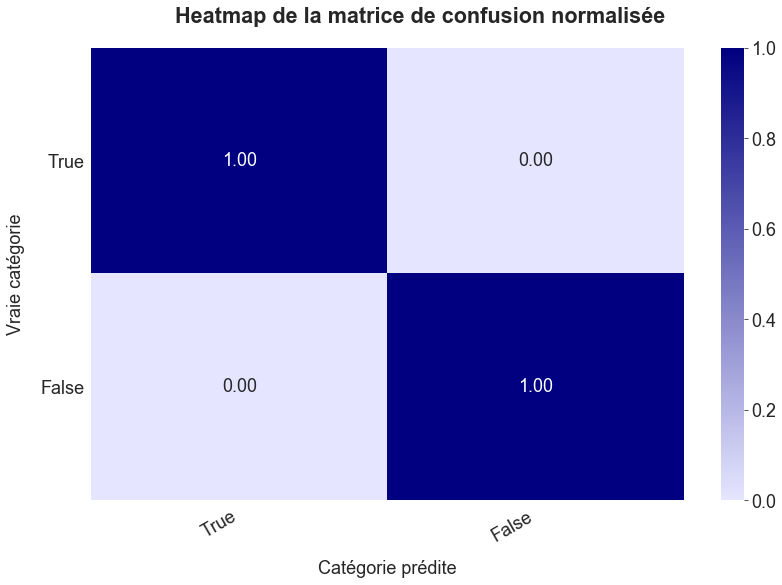

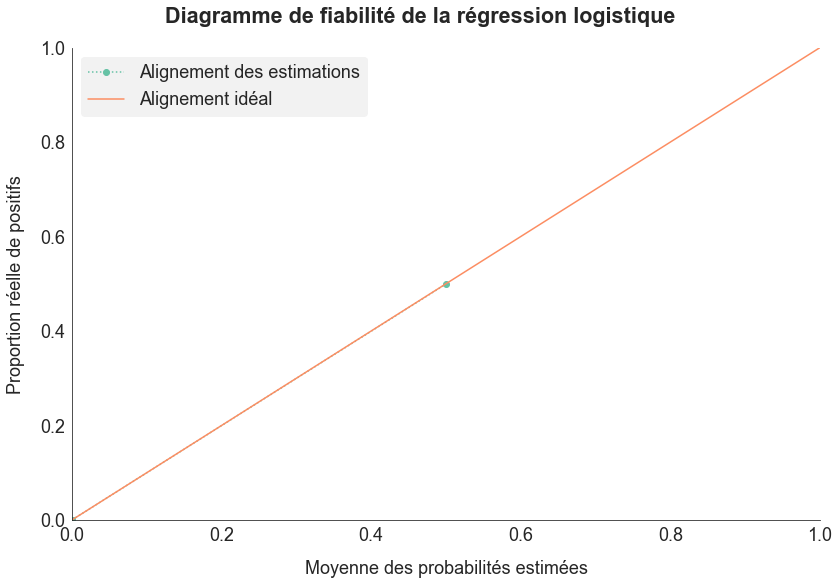

In [100]:
reg2.print_resultats()

In [101]:
fig, ax = reg2.graph_confusion_matrix(y_true=reg2.y, y_pred=reg2.df_y_estimates.binaire, pos_neg_labels=reg1.pos_neg_labels)
plt.savefig("p6_m3_g22_acp_heatmap.png")
plt.close(fig)

On remarque que la solution est sur-optimale. Les variables ne sont pas significatives : les p-values des coefficients estimés sont tous proches de 1. La matrice de confusion montre une séparation parfaite.  
Cependant, à la vue de notre analyse de l'ACP, cela ne fait pas de sens d'enlever le deuxième axe d'inertie. Je continue donc mon analyse sur ce modèle.

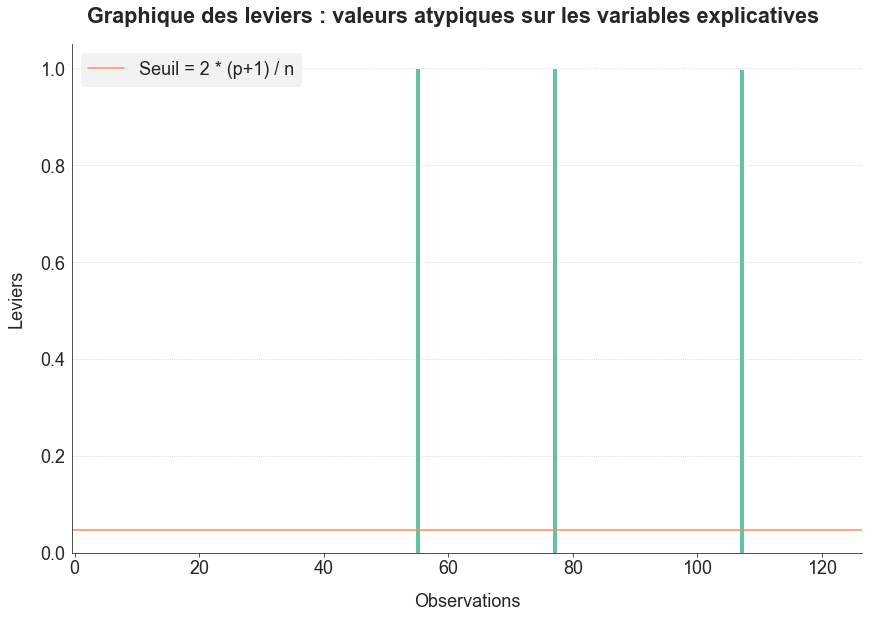

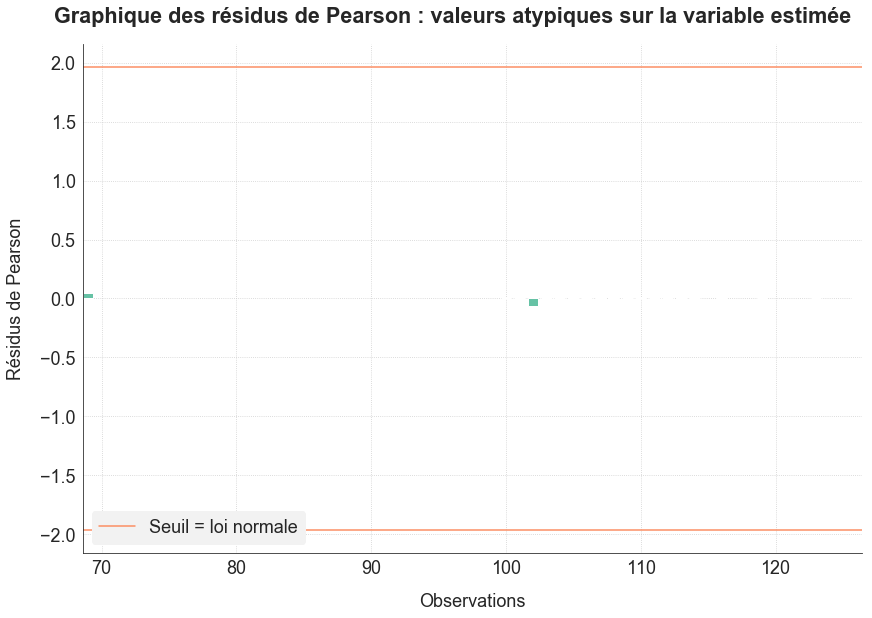

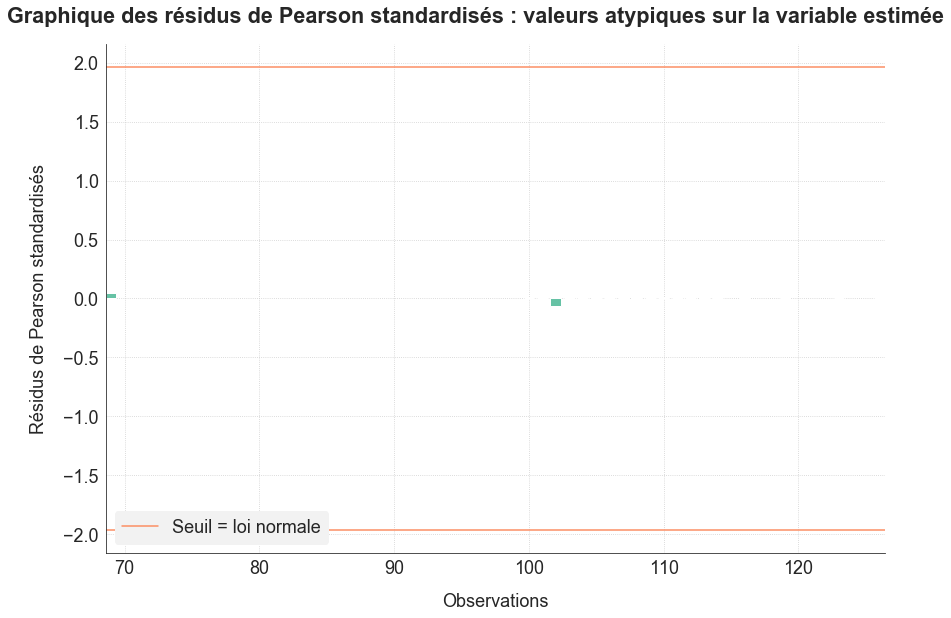

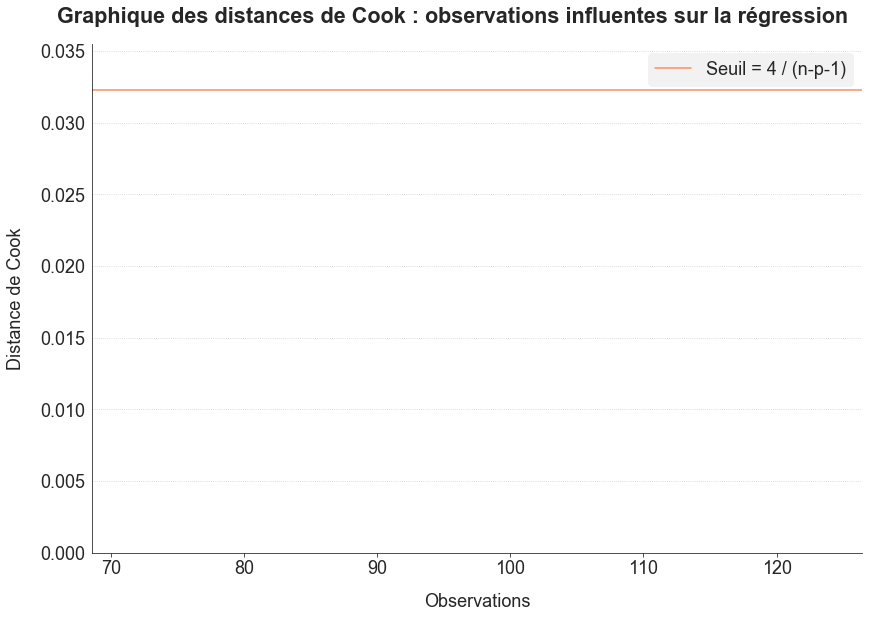


RAPPEL DES SEUILS
levier residus_pearson residus_pearson_standard   cook
 0.047           1.960                    1.960  0.032

RÉSUMÉ DES OBSERVATIONS ATYPIQUES OU INFLUENTES
     observation_name levier residus_pearson residus_pearson_standard  \
55                 69  1.000             nan                      nan   
77                102  1.000             nan                      nan   
107               144  1.000          -0.000                   -0.000   

     outlier cook_distance  influence  
55      True           nan      False  
77      True           nan      False  
107     True         0.000      False  

RÉSUMÉ DES OBSERVATIONS ATYPIQUES ET INFLUENTES
Ces variables sont à investiguer : elles sont atypiques et pèsent sur la régression
Empty DataFrame
Columns: [observation_name, levier, residus_pearson, residus_pearson_standard, outlier, cook_distance, influence]
Index: []



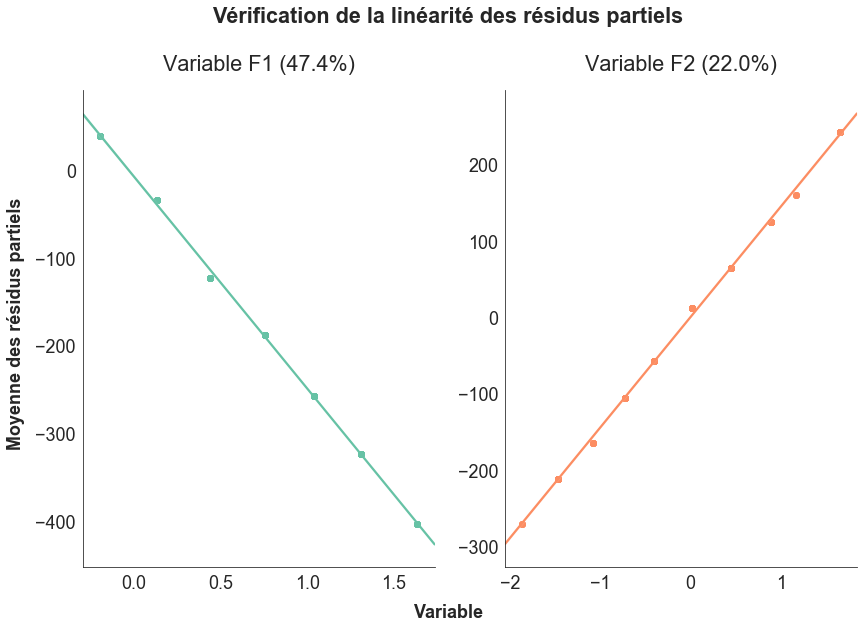

In [102]:
reg2.print_analyse_observations()

Il n'y a pas de données à la fois influentes et atypiques. RAS sur les observations. Le très bon alignement des moyennes des résidus partiels montre la très bonne relation obtenue.

Je dispose de 127 observations. Le respect des conditions sur les résidus n'est pas primordial pour la validité du modèle. Je vérifie quand même leur analyse.

NORMALITÉ DES RÉSIDUS

Test de Shapiro : p-value = 0.000.
L'hypothèse de normalité des résidus est rejetée.

Test de Jarque-Bera : p-value = 0.000.
L'hypothèse de normalité des résidus est rejetée.

Comme il y a plus de 30 observations (127), on peut accepter la normalité si la distribution est à peu près symétrique.



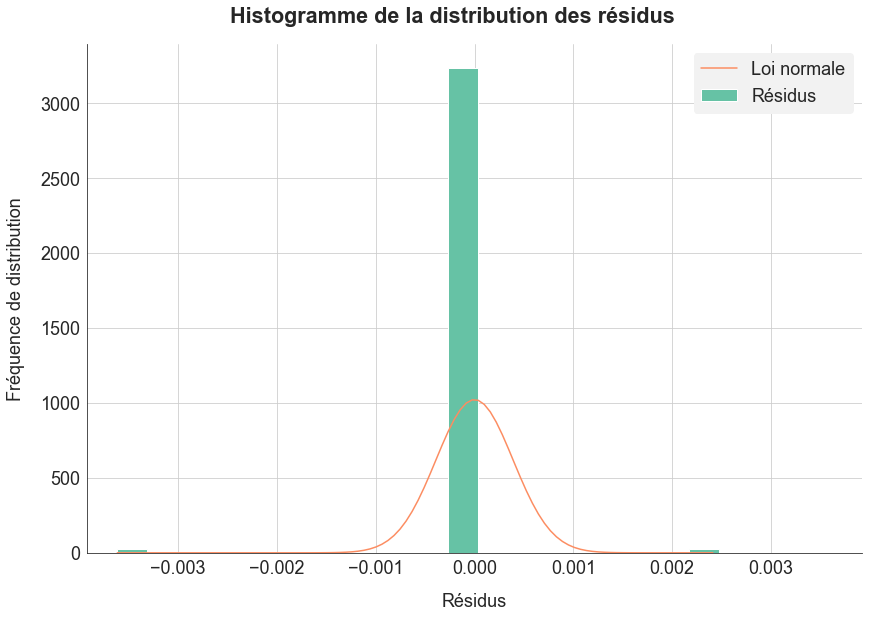

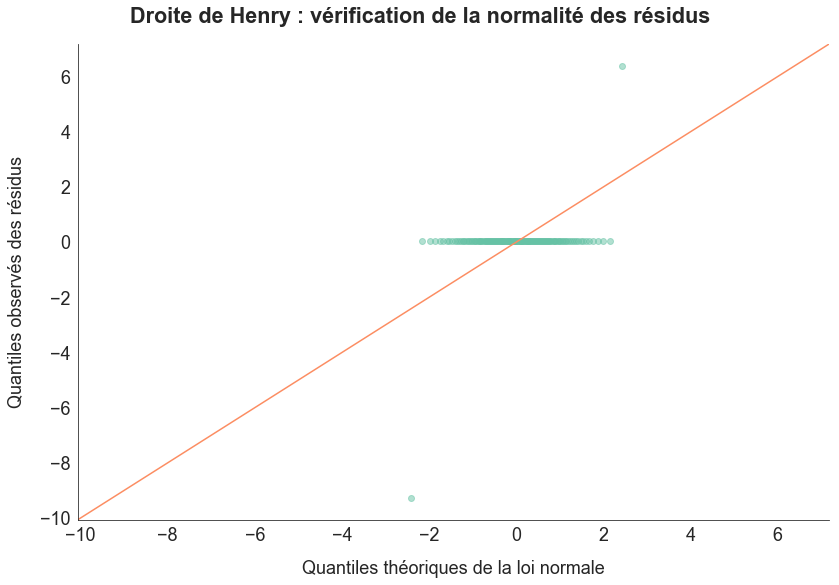


HOMOSCEDASTICITÉ DES RÉSIDUS

Dans le cadre de la régression logistique, la variance de l'erreur (= proba_estimee * (1-proba_estimee)) dépend des individus. Il y a hétéroscédasticité.



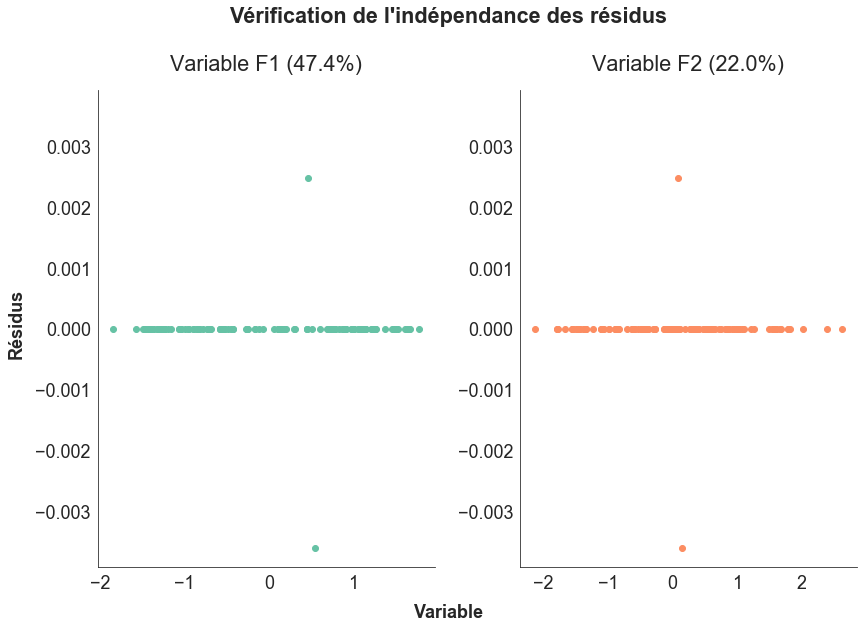

In [103]:
reg2.print_analyse_residus()

La distribution des résidus est symétrique autour de zéro. Du fait de la très bonne qualité de prédiction, il y a une sur-représentation des résidus nuls.  
  
Etant donné que les données sont issues d'une ACP, il ne doit pas y avoir de problèmes de colinéarité. Je vérifie pour la forme.

ANALYSE DE LA COLINÉARITÉ SIMPLE
Les valeurs de la matrice de corrélation doivent être inférieures à 0.8


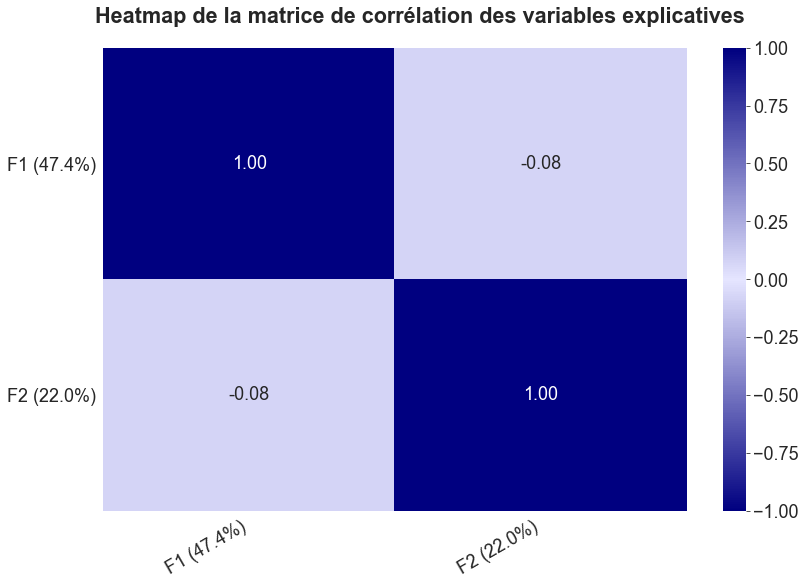


ANALYSE DE LA MULTI-COLINÉARITÉ
L'indice VIF doit être inférieur à 4
              VIF
F1 (47.4%)  1.006
F2 (22.0%)  1.006


In [104]:
reg2.print_analyse_colinearite()

In [105]:
fig, ax = reg2.graph_heatmap_correlationmatrix()
plt.savefig("p6_m3_g23_acp_correlation.png")
plt.close(fig)

<a id="4_2_2"></a>

#### <font color=blue>4.2.2. Validation croisée du modèle</font>

In [106]:
check2 = sfmcs.LogisticRegressionPrediction(data=data_acp.train, y_name=reg2.variable_estimee, array_X_names=reg2.variables_retenues)

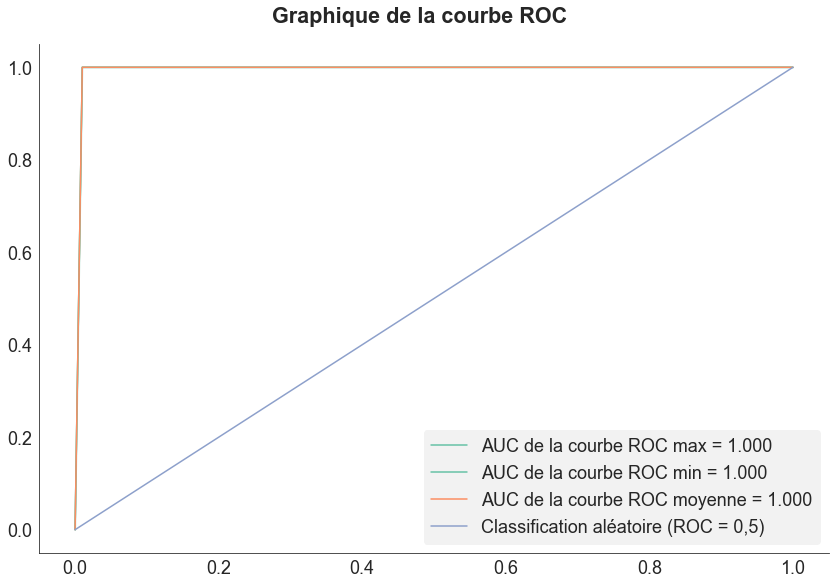

,0,1,2,3,4,moyenne,ecart_type
taux_succes,1.0,1.0,1.0,0.960000,1.0,0.992000,0.017889
f_mesure,1.0,1.0,1.0,0.965517,1.0,0.993103,0.015421
auc,1.0,1.0,1.0,0.993333,1.0,0.998667,0.002981
precision_rappel_score,1.0,1.0,1.0,0.995833,1.0,0.999167,0.001863


In [107]:
cv_results, fig, ax = check2.cross_validation()
plt.savefig("p6_m3_g24_acp_crossvalidation.png")
plt.show()
cv_results

<a id="4_2_3"></a>

#### <font color=blue>4.2.3. Vérification sur les données de test</font>

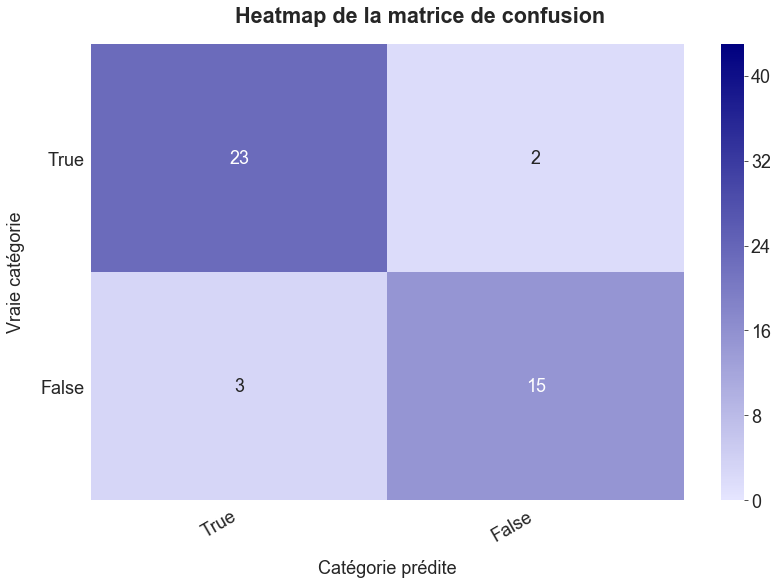

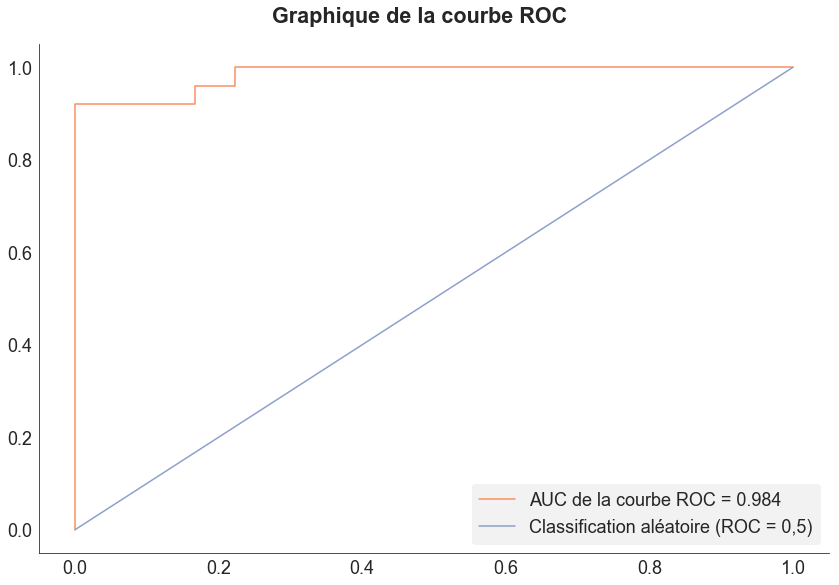

taux_succes               0.883721
f_mesure                  0.901961
auc                       0.984444
precision_rappel_score    0.990038


In [108]:
scores, fig_cm, ax_cm, fig_roc, ax_roc = check2.calcul_score_prediction(data_input=data_acp.test, true_y=data_acp.test[check2.variable_estimee])
fig_cm.savefig("p6_m3_g25_acp_test_matriceconfusion.png")
fig_roc.savefig("p6_m3_g26_acp_test_roccurve.png")
plt.show()
print(scores.to_string())

La validation croisée du modèle basé sur F1 et F2 obtient des résultats assez exceptionnels avec une moyenne supérieure à 0.99 pour les 4 mesures.  
La validation sur l'échantillon de test donne des résultats légèrement moins bons, mais qui demeurent très bons avec des mesures supérieures à 0.90.  
Ce modèle peut être utilisé à des fins de prédiction.

Je sauvegarde acp1 et check2 avec joblib, grâce aux objets dédiés à la production.

In [109]:
acp_acp = sfca.ProductionACP(acp1.data_variables, acp1.scaler, acp1.n_components, acp1.pca)
acp_logreg = sfmcs.ProductionLogisticRegression(check2.variable_estimee, check2.variables_explicatives, \
        check2.scaler, check2.with_constant, check2.method, check2.model, check2.classification)

In [110]:
joblib.dump(acp_acp, "acp_acp.joblib")
joblib.dump(acp_logreg, "acp_logreg.joblib")

['acp_logreg.joblib']

**Conclusions sur les modèles**

Je dispose donc de deux outils performants pour étudier l'authenticité d'un billet :  
- la régression logistique basée sur la longueur et la marge inférieure ;  
- la régression logistique basée sur le premier plan factoriel de l'ACP.  
  
Le modèle basé sur les mesures de la longueur et de la marge inférieure présente 2 avantages :
- il est plus sain car les coefficients sont significatifs. Les résultats sur les données de test à l'aveugle semblent d'ailleurs montrer une meilleure robustesse ;  
- il ne nécessite pas de passer par une étape intermédiaire de projection des données sur le premier plan factoriel de l'ACP. D'autant que l'ACP ne se justifie pas vraiment avec seulement 6 variables.

<a id="5_0"></a>

---
## <font color=blue>5. Prédictions</font>

Je teste mes deux modèles pour la prédiction avec les données d'exemple "soutenance_example.csv".

In [111]:
a_predire = pd.read_csv("soutenance_example.csv", index_col='id')
a_predire.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
id,,,,,,
A_1,171.76,104.01,103.54,5.21,3.30,111.42
A_2,171.87,104.17,104.13,6.00,3.31,112.09
A_3,172.00,104.58,104.29,4.99,3.39,111.57
A_4,172.49,104.55,104.34,4.44,3.03,113.20
A_5,171.65,103.63,103.56,3.77,3.16,113.33


**Prédictions avec le modèle check1 basé sur la longueur et la marge inférieure**

In [112]:
resultats1 = check1.calcul_prediction(data_input=a_predire)
resultats1

,length,margin_low,log_proba,proba,prediction
id,,,,,
A_1,111.42,5.21,-4.751511,0.008639,False
A_2,112.09,6.00,-5.627484,0.003598,False
A_3,111.57,4.99,-3.599766,0.027330,False
A_4,113.20,4.44,-0.058720,0.942971,True
A_5,113.33,3.77,-0.004192,0.995817,True


**Prédictions avec le modèle check2 basé sur le premier axe d'inertie de l'ACP**  
2 étapes : projection des individus sur les axes d'inertie puis calcul de la prédiction basée sur le premier plan factoriel.

In [113]:
acp_a_predire = acp1.calculate_newdata_projection(input_data=a_predire)
acp_a_predire.head()

,F1 (47.4%),F2 (22.0%),F3 (14.2%),F4 (8.5%),F5 (4.6%),F6 (3.2%)
id,,,,,,
A_1,0.430858,-1.547080,-0.323492,-1.095994,0.514887,0.457756
A_2,1.755599,-0.801172,0.621645,-0.160679,-0.596875,0.781043
A_3,2.441379,0.350431,-0.262608,0.255708,0.586026,-0.045267
A_4,0.885527,2.628610,0.681353,0.383339,0.169623,0.009772
A_5,-2.233949,-0.852742,-0.743062,0.352801,-0.118840,-0.163449


In [114]:
resultats2 = check2.calcul_prediction(data_input=acp_a_predire)
resultats2

,F1 (47.4%),F2 (22.0%),log_proba,proba,prediction
id,,,,,
A_1,0.430858,-1.547080,-2.371611,0.093330,False
A_2,1.755599,-0.801172,-3.762619,0.023223,False
A_3,2.441379,0.350431,-3.362720,0.034641,False
A_4,0.885527,2.628610,-0.039329,0.961434,True
A_5,-2.233949,-0.852742,-0.017621,0.982533,True


Les deux modèles fournissent le même résultat : les billets A1, A2 et A3 sont des faux billets alors que les billets A4 et A5 sont des billets authentiques.